#### Importing all the relevant libraries

In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization, StatsBase, Statistics, ProgressMeter, SpecialFunctions

#### Enums for the RPS action value

In [2]:
ROCK = 1
PAPER = 2
SCISSORS = 3

3

#### Some Default Hyper Parameters

In [3]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

#### This method returns the move that winning the move `opp_move`

In [4]:
function winning(opp_move)
    best_moves = Dict(ROCK => PAPER, PAPER => SCISSORS, SCISSORS => ROCK)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

### This function represents a RPS agent
#### `opponent_chn` - samples from opponent's posterior (according our model)
#### `opponent_history` - opponent's history moves
#### `anticipated_opp_prior_policy` - the prior of the agent on how his opponent play
#### `depth` - the depth of theory of mind we want our agent will "dive" \ explore

```
f(x) = print(y)
```

In [5]:
@model function agent(opponent_chn, opponent_history, anticipated_opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(anticipated_opp_prior_policy) #prior
    if depth == -1 # the simplest agent
        opponent_history = []
    end
    if depth <= 0
        for i in 1:length(opponent_history)
            opponent_history[i] ~ Categorical(beta_opp) # observe
        end
        next_opp_move ~ Categorical(beta_opp) # sample
    end
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:my_move][idx, 1]
        
        # init alternative way to Dirac distribution
        complete_p_dirac = (1 - PDIRAC) / 2
        phi = fill(complete_p_dirac, 3)
        phi[convert(Int, opp_move_sample)] = PDIRAC
        
        next_opp_move ~ Categorical(phi) # observe
    end
    winning_move = winning(next_opp_move)
    
    # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[convert(Int,winning_move)] = PDIRAC
    
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

#### This function plot an histogram on the posterior of agent's moves (computed policy)

In [6]:
# Plot the results
function plotChn(chn)
    histogram(chn[:my_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

#### This function is implemntation of Dynamic Programming on one agent's proccess of theory of mind

In [7]:
function run_two_agents_theory_of_mind(my_model, other_model, estimating_opponent_prior, opponent_estimating_my_prior, opponent_history, my_history, depth, show_progress = true)
    second_chn_i = []
    first_chn_i = []
    p = Progress(depth)
    if depth == -1
        first_chn_i = sample(other_model(second_chn_i, my_history, opponent_estimating_my_prior, -1), INFALG, N , n_chains=1,progress = false)
        second_chn_i = sample(my_model(first_chn_i, opponent_history, estimating_opponent_prior, -1),  INFALG, N , n_chains=1, progress = false) 
    end 
    for i in 0:depth
        first_chn_i = sample(other_model(second_chn_i, my_history, opponent_estimating_my_prior, i), INFALG, N , n_chains=1, progress = false)
        second_chn_i = sample(my_model(first_chn_i, opponent_history, estimating_opponent_prior, i),  INFALG, N , n_chains=1, progress = false)
        if show_progress
            ProgressMeter.next!(p)
        end
    end
    return second_chn_i
end

run_two_agents_theory_of_mind (generic function with 2 methods)

### In the following plots we will show:<br> when depth -> Infinity then policy -> Nash-EQ

#### Depth -1

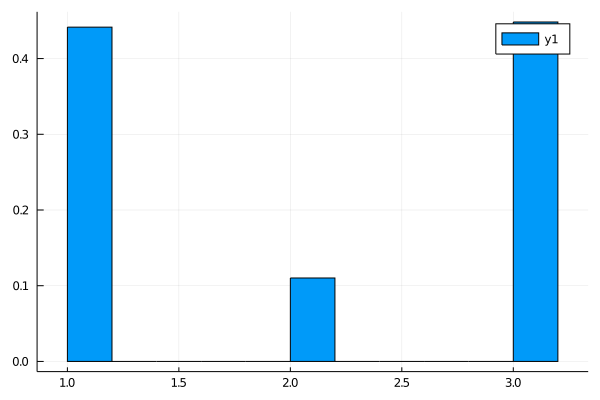

In [8]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,9,2], [], [], -1))

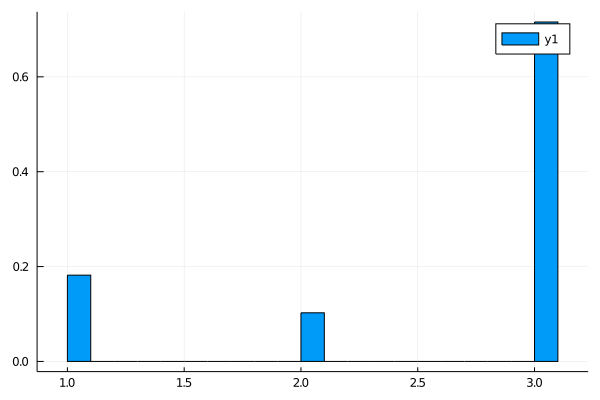

In [32]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,9,2] , [1,9,2], [], [], -1))

### Depth 0

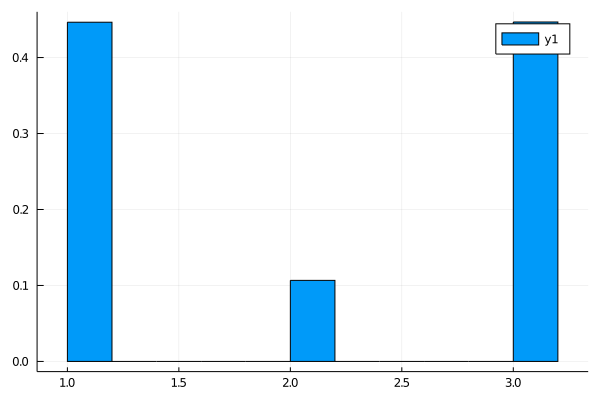

In [33]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

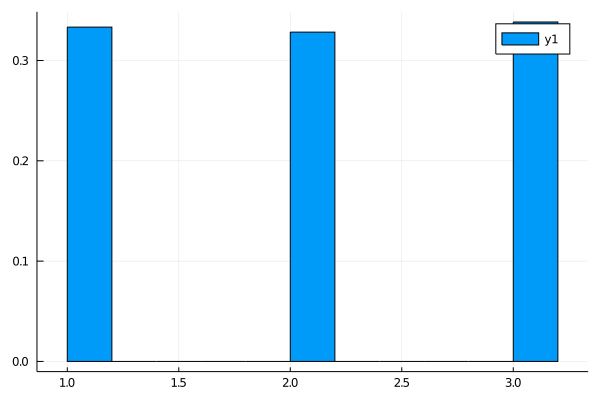

In [34]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 0))

### Depth 1

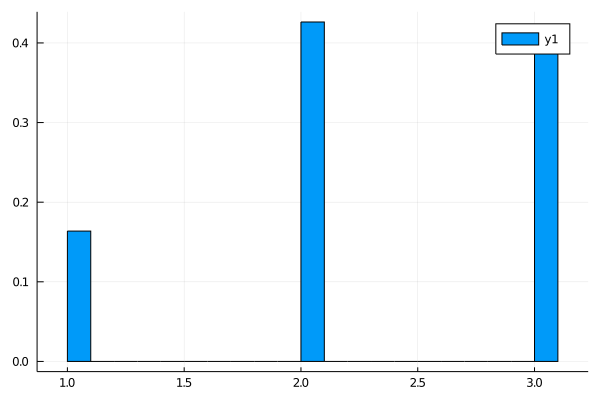

In [12]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 1))

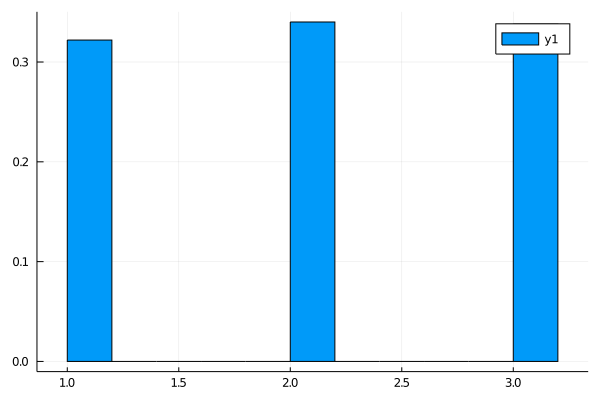

In [13]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 1))

### Depth 2

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


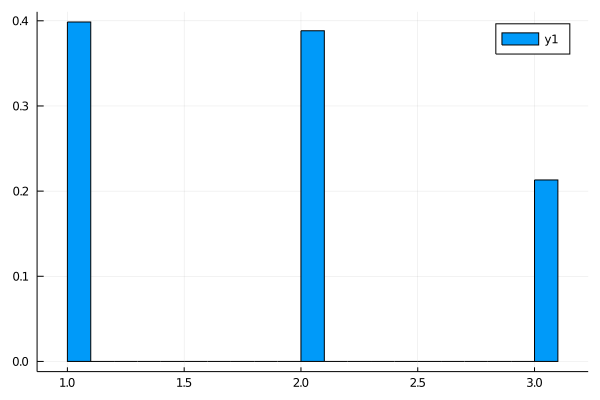

In [14]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 2))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


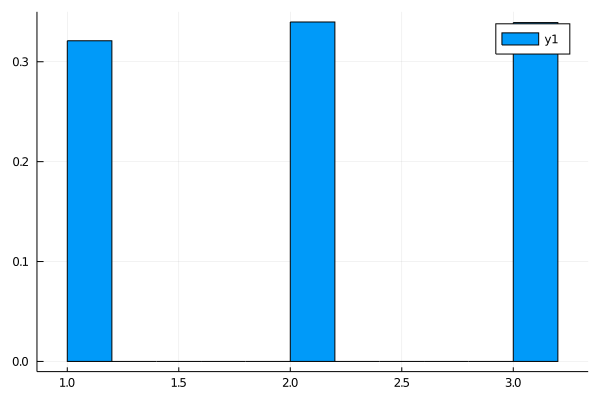

In [15]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 2))

### Depth 3

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


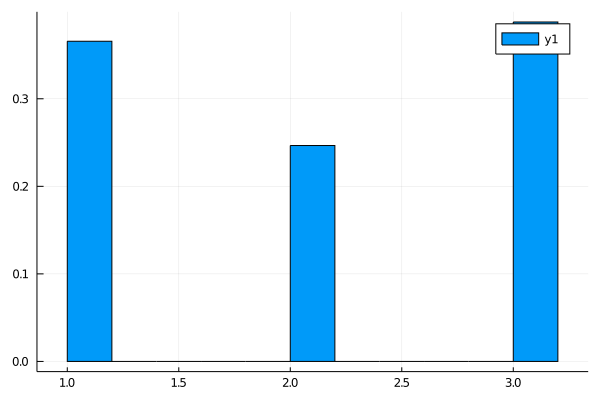

In [35]:
plotChn(run_two_agents_theory_of_mind(agent, agent,[1,5,5], [1,1,1], [], [], 3))

### We can see here a minor rotation (a phonmenon we will discuss) - Depth 4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


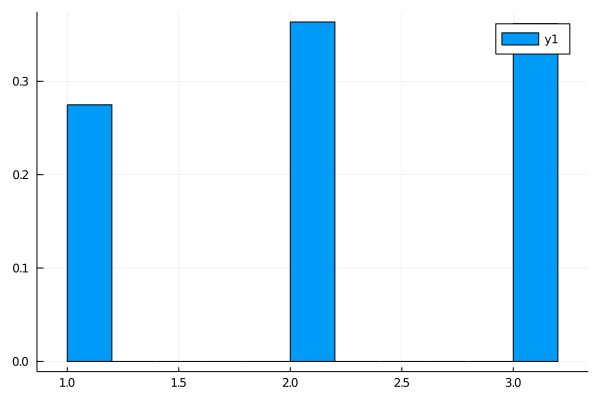

In [39]:
plotChn(run_two_agents_theory_of_mind(agent, agent,[1,5,5], [1,1,1], [], [], 4))

### We can see here a minor rotation (a phonmenon we will discuss) - Depth 5

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


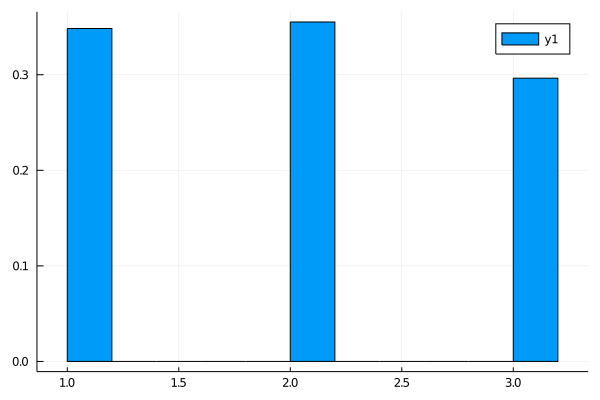

In [41]:
plotChn(run_two_agents_theory_of_mind(agent, agent,[1,5,5], [1,1,1], [], [], 5))

### Depth 3 - Posterior policy (almost Nash-eq)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


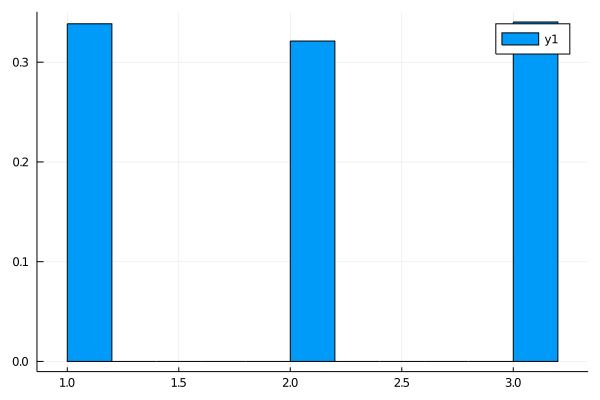

In [36]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 3))

### We still can see here a minor rotation (a phonmenon we will discuss) - Depth 4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


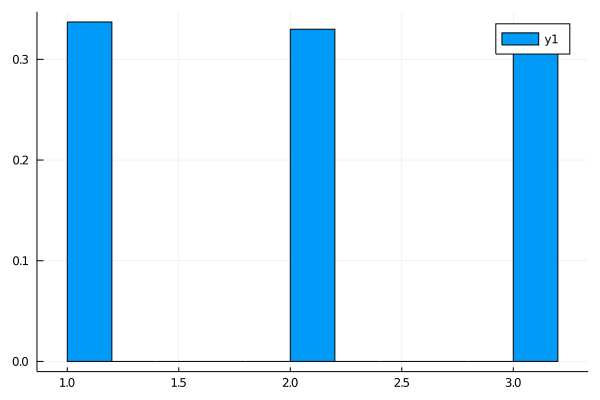

In [40]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 4))

### We still can see here a minor rotation (a phonmenon we will discuss) - Depth 5

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


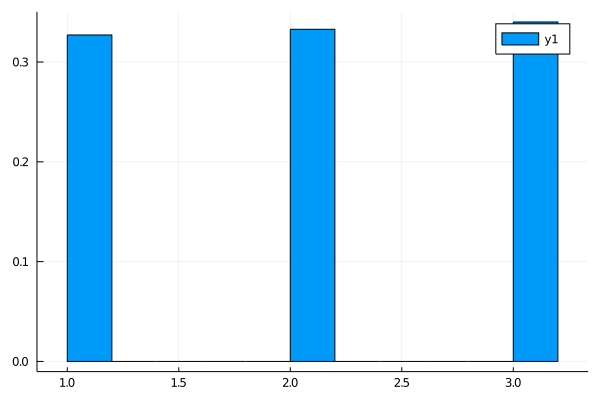

In [42]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 5))

### Depth 9 - We already got to Nash-EQ (approximately)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


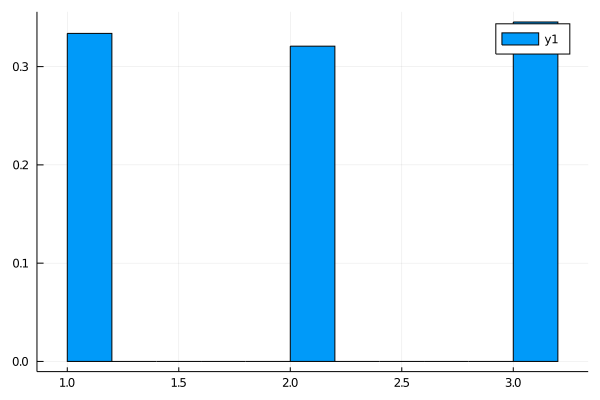

In [8]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5], [1,1,1], [], [], 9))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


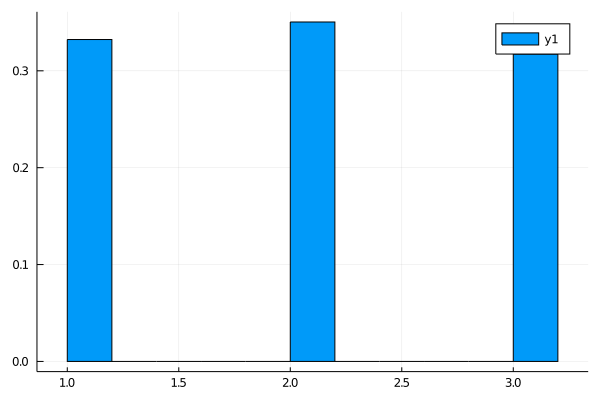

In [9]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 9))

### Depth 10 - We already got to Nash-EQ (approximately)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


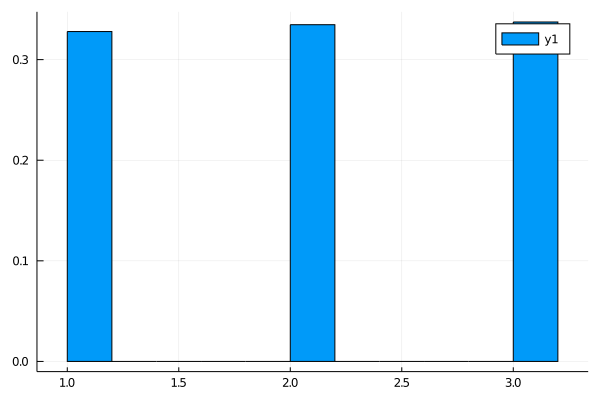

In [10]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5], [1,1,1], [], [], 10))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


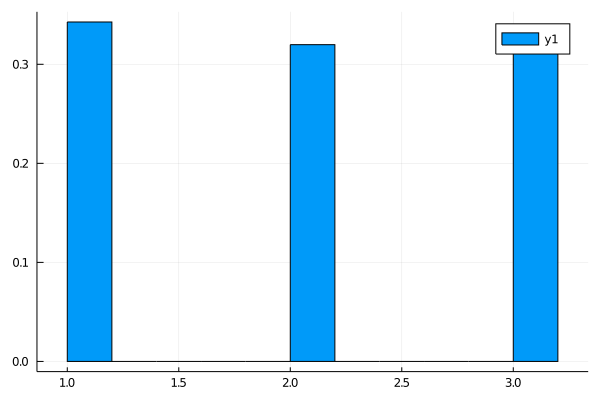

In [11]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 10))

### In The Follwing Section:<br>
#### Programming simulation of two agents competing each other<br>
<ul>
    <li> The simulation include all the operators to make the game possible
    <li> Adding it a Dynamic Nature, the history also comming into consideration
    <li> We show some interseting expirments as a function of `theory_of_mind` `depth` of the agents
    <li> We can see that as similiar to the "Static" game when depth go to Infinity the policy goes to Nash-EQ.<br>
      Also when `num_of_turns` goes to Infinity (in agents that take history to consideration) - policy goes to Nash-EQ.
</ul>

### Simulations

In [17]:
function sample_move(chn)
    weights = exp.(chn[:lp][:, 1])
    weights = Weights(weights/sum(weights))
    idx = sample(collect(1:length(weights)), weights)
    move_sample = chn[:my_move][idx, 1]
    return move_sample
end

sample_move (generic function with 1 method)

#### Playing the winning move in propotion to expected policy

In [18]:
function compute_counter_policy(policy)
    return circshift(policy, 1)
end

compute_counter_policy (generic function with 1 method)

#### This function simulates selection a move of `agent` based on:
<ol>
    <li> `other_agent`
    <li> `other_agent_history`
    <li> `my_history`
    <li> `my_estimated_opponent_policy`
    <li> `my_depth`
<ol>

In [19]:
function move(agent, other_agent, other_agent_history, my_history, my_estimated_opponent_policy, my_depth)
    other_agent_history = length(other_agent_history) > 0 ? other_agent_history : [1]
    other_agent_history = Array{Int}(other_agent_history)
    my_history = length(my_history) > 0 ? my_history : [1]
    my_history = Array{Int}(my_history)
    
    # TODO - how to simullate the opponent thinking on my policy
    # For now as best we think it is the policy the beaten by <my_estimated_opponent_policy> 
    opponent_estimation_of_my_policy = compute_counter_policy(my_estimated_opponent_policy)
    chain = run_two_agents_theory_of_mind(agent, other_agent, my_estimated_opponent_policy, opponent_estimation_of_my_policy , other_agent_history, my_history, my_depth, false)
    return sample_move(chain), chain
end

move (generic function with 1 method)

### Simulation of Game between two agents
#### The agents don't save and update their policy, the compute it each time from scrach

In [20]:
function game(first_player_depth = 1, second_player_depth = 1, first_player_estimating_opponent_policy = [1,1,1] , second_player_estimating_opponent_policy = [1, 1, 1], num_of_rounds = 50)
    first_player = agent
    second_player = agent
    first_player_history = []
    second_player_history = []
    first_player_theoretical_score = []
    # @showprogress  
    for i in 1:num_of_rounds
        m1, chain1 = move(first_player, second_player, second_player_history, first_player_history, first_player_estimating_opponent_policy, first_player_depth)
        push!(first_player_history, m1)
        m2, chain2 = move(second_player, first_player, first_player_history, second_player_history, second_player_estimating_opponent_policy, second_player_depth)
        push!(second_player_history, m2)
        
        ts = compute_theoretical_score(chain1, chain2)
        push!(first_player_theoretical_score, ts)
    end
    return first_player_history, second_player_history, first_player_theoretical_score
 end

game (generic function with 6 methods)

#### mapping between a Move and the move that losing by this move

In [21]:
wins = Dict(ROCK => SCISSORS, PAPER => ROCK, SCISSORS => PAPER)

Dict{Int64,Int64} with 3 entries:
  2 => 1
  3 => 2
  1 => 3

#### Given history of the game (as tuple of (`first_player_moves`, `second_player_history` , `first_player_theoretical_score` ) return the score of the game (`first_wins`, `ties`, `second_wins`)

In [22]:
function score(game_history)
    first_player_history, second_player_history , _ = game_history
    first_wins = 0
    ties = 0
    second_wins = 0
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            first_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            second_wins += 1
        else
            ties += 1
        end
    end
    return [first_wins, ties, second_wins]
end

score (generic function with 1 method)

In [23]:
NUM_OF_MC_SIMULATIONS = 5000

5000

#### This function makes a `num_of_mc_simulations` of Monte-Carlo simulations given `first_policy` , `second_policy` and returns the average win of the player of `first_policy`

In [24]:
function mc_simulation(first_policy, second_policy, num_of_mc_simulations = NUM_OF_MC_SIMULATIONS)
    first_weights = Weights(first_policy/sum(first_policy))
    first_moves = sample(collect(1:length(first_weights)), first_weights, num_of_mc_simulations)
    second_weights = Weights(second_policy/sum(second_policy))
    second_moves = sample(collect(1:length(second_weights)), second_weights, num_of_mc_simulations)
    first, tie, second = score([first_moves, second_moves, [], []])
    return (first - second) / num_of_mc_simulations
end

mc_simulation (generic function with 2 methods)

#### This function makes a `num_of_mc_simulations` of Monte-Carlo simulations given `first_chain` , `second_chain` and returns the average win of the player of `first_chain`

In [25]:
function compute_theoretical_score(first_chain, second_chain)
    first_weights = exp.(first_chain[:lp][:, 1])
    first_weights = Weights(first_weights/sum(first_weights))
    first_sampled_moves = sample(first_chain[:my_move], first_weights, NUM_OF_MC_SIMULATIONS)
    second_weights = exp.(second_chain[:lp][:, 1])
    second_weights = Weights(second_weights/sum(second_weights))
    second_sampled_moves = sample(second_chain[:my_move], second_weights, NUM_OF_MC_SIMULATIONS)
    first, tie, second = score([first_sampled_moves, second_sampled_moves, []])
    return (first - second) / NUM_OF_MC_SIMULATIONS
end

compute_theoretical_score (generic function with 1 method)

#### This function aggregates the score through all round to show the "Dynamics" of the game

In [26]:
function accumulated_score(history)
    first_player_history, second_player_history , _ = history
    first_wins, ties, second_wins = 0, 0, 0
    acc_result = []
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            first_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            second_wins += 1
        else
            ties += 1
        end
        push!(acc_result, [first_wins, ties, second_wins])
    end
    return acc_result
end

accumulated_score (generic function with 1 method)

#### This function visualize the accumulated_score 

In [27]:
function plot_accumulated_score(acc_result)
    n = length(acc_result)
    acc_result = transpose(reduce(hcat, acc_result))
    plot(1:n, acc_result, alpha = 0.3)
end

plot_accumulated_score (generic function with 1 method)

#### This function just prints all the scores

In [28]:
function display_score(score)
    num_of_wins_first, num_of_ties, num_of_wins_second = score
    println("first player won: $num_of_wins_first")
    println("second player won: $num_of_wins_second") 
    println("ties: $num_of_ties") 
end

display_score (generic function with 1 method)

#### This function return the mean and the std of 1st_win , ties, 2nd_win for a specific game

In [29]:
function mean_and_var(results)
    results = reduce(hcat, results)
    mean_results = mean(results,dims=2)
    var_results = std(results,dims=2)
    return mean_results , var_results
end

mean_and_var (generic function with 1 method)

#### Number of diffrent games to play

In [30]:
NUM_OF_EXPIREMENTS = 30

30

#### This function simulates `num_of_expirements` games , and compute the statiscs of actual `1st_player_wins`, `ties` , `2nd_player_wins` overall games

In [35]:
function simulate_game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = 10, num_of_rounds = 50)
    result_plt = plot(title = "Game Results")
    ts_plt = plot(title = "Score Based on MC Simulations")
    scores = []
    mc_scores = []
    for i in 1:num_of_expirements
        game_result = game(first_player_depth,second_player_depth, first_player_prior_policy, second_player_prior_policy)
        acc_result = accumulated_score(game_result)
        score_result = score(game_result)
        push!(scores,score_result)
        n = length(acc_result)
        acc_result = transpose(reduce(hcat, acc_result))
        plot!(result_plt, acc_result, alpha = 0.3, legend = false, label = ["p1 wins" "ties" "p2 wins"] , color = [1 2 3])
        
        _ , _ , ts_score = game_result
        push!(mc_scores, ts_score)
        plot!(ts_plt, ts_score , alpha = 0.3, legend = false, color = [1])
    end
    display(result_plt)
    mean_results, var_results = mean_and_var(scores)
    println("first win: $(mean_results[1])+-$(var_results[1])")
    println("ties: $(mean_results[2])+-$(var_results[2])")
    println("second win: $(mean_results[3])+-$(var_results[3])")
    plot!(ts_plt, mean(mc_scores))
    display(ts_plt)
end 

simulate_game (generic function with 7 methods)

#### This function simulates how `my_depth` player perform vs opponents from -1 depth to `my_depth`. plotting the mean of the theoreticl score

In [36]:
function simulate_depth(my_depth, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = 10, num_of_rounds=50)
    plt = plot(title = "Score Based on MC Simulations $my_depth")
    for opponent_depth in -1:my_depth
        println("Opponent Depth: $opponent_depth")
        mc_scores = []
        for i in 1:num_of_expirements
            println("Opponent Depth: $opponent_depth, Expirment #$i")
            game_result = game(my_depth, opponent_depth, first_player_prior_policy, second_player_prior_policy, num_of_rounds)
            _, _ , mc_score = game_result
            push!(mc_scores, mc_score)
        end
        plot!(plt, mean(mc_scores), ribbon=std(mc_scores), label ="$opponent_depth")
    end
    display(plt)
end

simulate_depth (generic function with 5 methods)

#### This function simulates how my depth iterating from -1 to `opponents_depth` perform vs `opponent_depth` player. plotting the mean of the theoreticl score

In [33]:
function simulate_opponent_depth(opponent_depth, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = NUM_OF_EXPIREMENTS, max_depth = 4)
    plt = plot(title = "Score Based on MC Simulations Opponent Depth $opponent_depth")
    for my_depth in -1:max_depth
        println("My Depth: $my_depth")
        mc_scores = []
        for i in 1:num_of_expirements
            println("Opponent Depth: $opponent_depth, Expirment #$i")
            game_result = game(my_depth, opponent_depth, first_player_prior_policy, second_player_prior_policy)
            _, _ , mc_score = game_result
            push!(mc_scores, mc_score)
        end
        plot!(plt, mean(mc_scores), ribbon=std(mc_scores), label ="My Depth: $my_depth")
    end
    display(plt)
end

simulate_opponent_depth (generic function with 5 methods)

Opponent Depth: -1
Opponent Depth: -1, Expirment #1
Opponent Depth: -1, Expirment #2
Opponent Depth: -1, Expirment #3
Opponent Depth: -1, Expirment #4
Opponent Depth: -1, Expirment #5
Opponent Depth: -1, Expirment #6
Opponent Depth: -1, Expirment #7
Opponent Depth: -1, Expirment #8
Opponent Depth: -1, Expirment #9
Opponent Depth: -1, Expirment #10
Opponent Depth: -1, Expirment #11
Opponent Depth: -1, Expirment #12
Opponent Depth: -1, Expirment #13
Opponent Depth: -1, Expirment #14
Opponent Depth: -1, Expirment #15
Opponent Depth: -1, Expirment #16
Opponent Depth: -1, Expirment #17
Opponent Depth: -1, Expirment #18
Opponent Depth: -1, Expirment #19
Opponent Depth: -1, Expirment #20
Opponent Depth: -1, Expirment #21
Opponent Depth: -1, Expirment #22
Opponent Depth: -1, Expirment #23
Opponent Depth: -1, Expirment #24
Opponent Depth: -1, Expirment #25
Opponent Depth: -1, Expirment #26
Opponent Depth: -1, Expirment #27
Opponent Depth: -1, Expirment #28
Opponent Depth: -1, Expirment #29


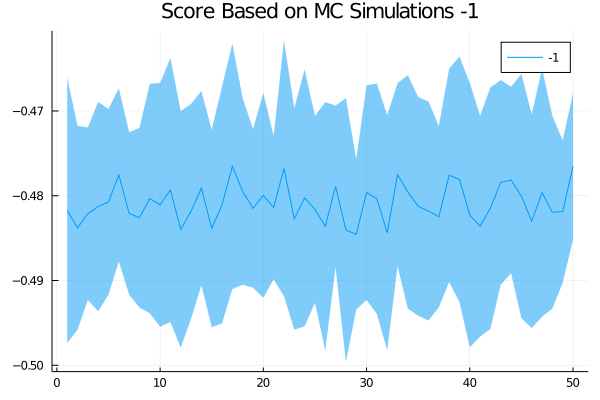

Opponent Depth: -1, Expirment #30


In [26]:
simulate_depth(-1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Opponent Depth: -1
Opponent Depth: -1, Expirment #1
Opponent Depth: -1, Expirment #2
Opponent Depth: -1, Expirment #3
Opponent Depth: -1, Expirment #4
Opponent Depth: -1, Expirment #5
Opponent Depth: -1, Expirment #6
Opponent Depth: -1, Expirment #7
Opponent Depth: -1, Expirment #8
Opponent Depth: -1, Expirment #9
Opponent Depth: -1, Expirment #10
Opponent Depth: -1, Expirment #11
Opponent Depth: -1, Expirment #12
Opponent Depth: -1, Expirment #13
Opponent Depth: -1, Expirment #14
Opponent Depth: -1, Expirment #15
Opponent Depth: 0
Opponent Depth: 0, Expirment #1
Opponent Depth: 0, Expirment #2
Opponent Depth: 0, Expirment #3
Opponent Depth: 0, Expirment #4
Opponent Depth: 0, Expirment #5
Opponent Depth: 0, Expirment #6
Opponent Depth: 0, Expirment #7
Opponent Depth: 0, Expirment #8
Opponent Depth: 0, Expirment #9
Opponent Depth: 0, Expirment #10
Opponent Depth: 0, Expirment #11
Opponent Depth: 0, Expirment #12
Opponent Depth: 0, Expirment #13
Opponent Depth: 0, Expirment #14


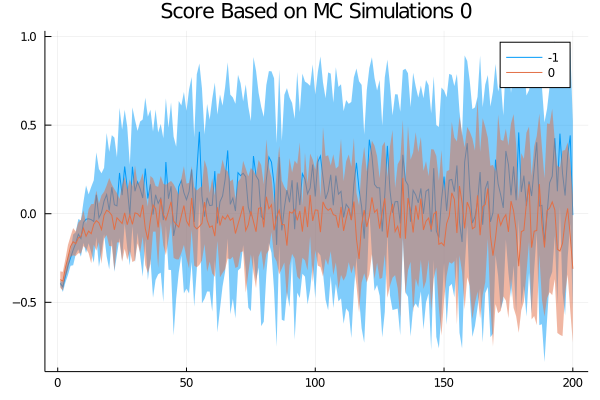

Opponent Depth: 0, Expirment #15


In [38]:
simulate_depth(0, [1,10,1], [1,1,10], 15, 200)

Opponent Depth: -1
Opponent Depth: -1, Expirment #1
Opponent Depth: -1, Expirment #2
Opponent Depth: -1, Expirment #3
Opponent Depth: -1, Expirment #4
Opponent Depth: -1, Expirment #5
Opponent Depth: -1, Expirment #6
Opponent Depth: -1, Expirment #7
Opponent Depth: -1, Expirment #8
Opponent Depth: -1, Expirment #9
Opponent Depth: -1, Expirment #10
Opponent Depth: -1, Expirment #11
Opponent Depth: -1, Expirment #12
Opponent Depth: -1, Expirment #13
Opponent Depth: -1, Expirment #14
Opponent Depth: -1, Expirment #15
Opponent Depth: -1, Expirment #16
Opponent Depth: -1, Expirment #17
Opponent Depth: -1, Expirment #18
Opponent Depth: -1, Expirment #19
Opponent Depth: -1, Expirment #20
Opponent Depth: -1, Expirment #21
Opponent Depth: -1, Expirment #22
Opponent Depth: -1, Expirment #23
Opponent Depth: -1, Expirment #24
Opponent Depth: -1, Expirment #25
Opponent Depth: -1, Expirment #26
Opponent Depth: -1, Expirment #27
Opponent Depth: -1, Expirment #28
Opponent Depth: -1, Expirment #29
Oppo

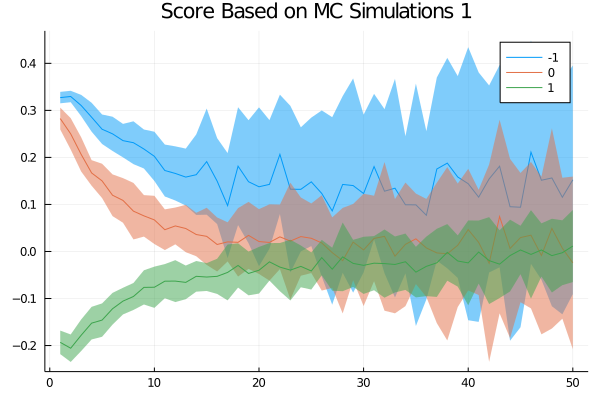

Opponent Depth: 1, Expirment #30


In [71]:
simulate_depth(1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Opponent Depth: -1
Opponent Depth: -1, Expirment #1
Opponent Depth: -1, Expirment #2
Opponent Depth: -1, Expirment #3
Opponent Depth: -1, Expirment #4
Opponent Depth: -1, Expirment #5
Opponent Depth: -1, Expirment #6
Opponent Depth: -1, Expirment #7
Opponent Depth: -1, Expirment #8
Opponent Depth: -1, Expirment #9
Opponent Depth: -1, Expirment #10
Opponent Depth: -1, Expirment #11
Opponent Depth: -1, Expirment #12
Opponent Depth: -1, Expirment #13
Opponent Depth: -1, Expirment #14
Opponent Depth: -1, Expirment #15
Opponent Depth: -1, Expirment #16
Opponent Depth: -1, Expirment #17
Opponent Depth: -1, Expirment #18
Opponent Depth: -1, Expirment #19
Opponent Depth: -1, Expirment #20
Opponent Depth: -1, Expirment #21
Opponent Depth: -1, Expirment #22
Opponent Depth: -1, Expirment #23
Opponent Depth: -1, Expirment #24
Opponent Depth: -1, Expirment #25
Opponent Depth: -1, Expirment #26
Opponent Depth: -1, Expirment #27
Opponent Depth: -1, Expirment #28
Opponent Depth: -1, Expirment #29
Oppo

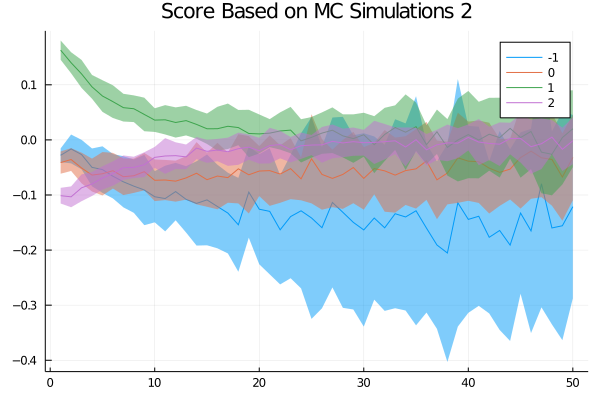

Opponent Depth: 2, Expirment #30


In [72]:
simulate_depth(2, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Opponent Depth: -1
Opponent Depth: -1, Expirment #1
Opponent Depth: -1, Expirment #2
Opponent Depth: -1, Expirment #3
Opponent Depth: -1, Expirment #4
Opponent Depth: -1, Expirment #5
Opponent Depth: -1, Expirment #6
Opponent Depth: -1, Expirment #7
Opponent Depth: -1, Expirment #8
Opponent Depth: -1, Expirment #9
Opponent Depth: -1, Expirment #10
Opponent Depth: -1, Expirment #11
Opponent Depth: -1, Expirment #12
Opponent Depth: -1, Expirment #13
Opponent Depth: -1, Expirment #14
Opponent Depth: -1, Expirment #15
Opponent Depth: -1, Expirment #16
Opponent Depth: -1, Expirment #17
Opponent Depth: -1, Expirment #18
Opponent Depth: -1, Expirment #19
Opponent Depth: -1, Expirment #20
Opponent Depth: -1, Expirment #21
Opponent Depth: -1, Expirment #22
Opponent Depth: -1, Expirment #23
Opponent Depth: -1, Expirment #24
Opponent Depth: -1, Expirment #25
Opponent Depth: -1, Expirment #26
Opponent Depth: -1, Expirment #27
Opponent Depth: -1, Expirment #28
Opponent Depth: -1, Expirment #29
Oppo

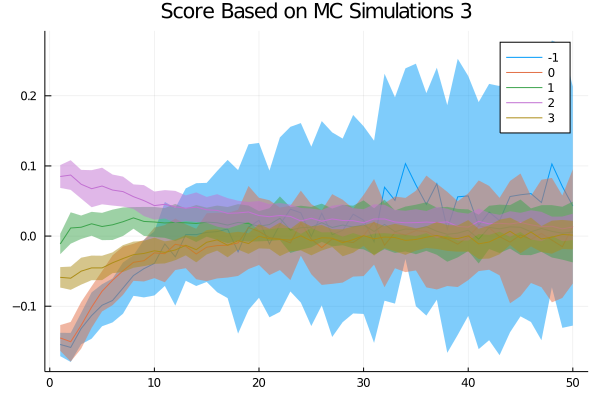

Opponent Depth: 3, Expirment #30


In [26]:
simulate_depth(3, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Opponent Depth: -1
Opponent Depth: -1, Expirment #1
Opponent Depth: -1, Expirment #2
Opponent Depth: -1, Expirment #3
Opponent Depth: -1, Expirment #4
Opponent Depth: -1, Expirment #5
Opponent Depth: -1, Expirment #6
Opponent Depth: -1, Expirment #7
Opponent Depth: -1, Expirment #8
Opponent Depth: -1, Expirment #9
Opponent Depth: -1, Expirment #10
Opponent Depth: -1, Expirment #11
Opponent Depth: -1, Expirment #12
Opponent Depth: -1, Expirment #13
Opponent Depth: -1, Expirment #14
Opponent Depth: -1, Expirment #15
Opponent Depth: -1, Expirment #16
Opponent Depth: -1, Expirment #17
Opponent Depth: -1, Expirment #18
Opponent Depth: -1, Expirment #19
Opponent Depth: -1, Expirment #20
Opponent Depth: -1, Expirment #21
Opponent Depth: -1, Expirment #22
Opponent Depth: -1, Expirment #23
Opponent Depth: -1, Expirment #24
Opponent Depth: -1, Expirment #25
Opponent Depth: -1, Expirment #26
Opponent Depth: -1, Expirment #27
Opponent Depth: -1, Expirment #28
Opponent Depth: -1, Expirment #29
Oppo

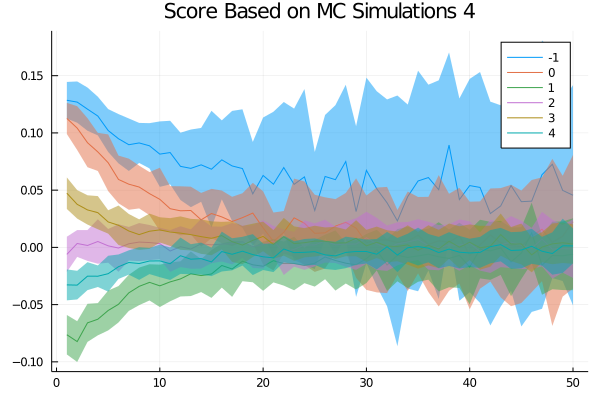


Opponent Depth: 4, Expirment #30


In [27]:
simulate_depth(4, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

In [ ]:
simulate_depth(5, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Opponent Depth: -1
Opponent Depth: -1, Expirment #1
Opponent Depth: -1, Expirment #2


In [ ]:
simulate_depth(6, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

In [ ]:
simulate_depth(7, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

My Depth: -1
Opponent Depth: -1, Expirment #1
Opponent Depth: -1, Expirment #2
Opponent Depth: -1, Expirment #3
Opponent Depth: -1, Expirment #4
Opponent Depth: -1, Expirment #5
Opponent Depth: -1, Expirment #6
Opponent Depth: -1, Expirment #7
Opponent Depth: -1, Expirment #8
Opponent Depth: -1, Expirment #9
Opponent Depth: -1, Expirment #10
Opponent Depth: -1, Expirment #11
Opponent Depth: -1, Expirment #12
Opponent Depth: -1, Expirment #13
Opponent Depth: -1, Expirment #14
Opponent Depth: -1, Expirment #15
Opponent Depth: -1, Expirment #16
Opponent Depth: -1, Expirment #17
Opponent Depth: -1, Expirment #18
Opponent Depth: -1, Expirment #19
Opponent Depth: -1, Expirment #20
Opponent Depth: -1, Expirment #21
Opponent Depth: -1, Expirment #22
Opponent Depth: -1, Expirment #23
Opponent Depth: -1, Expirment #24
Opponent Depth: -1, Expirment #25
Opponent Depth: -1, Expirment #26
Opponent Depth: -1, Expirment #27
Opponent Depth: -1, Expirment #28
Opponent Depth: -1, Expirment #29
Opponent D

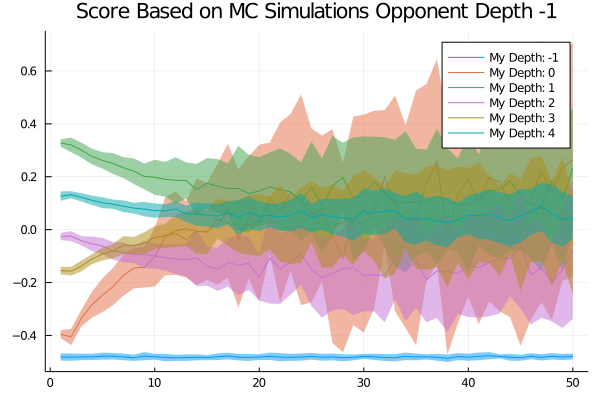

Opponent Depth: -1, Expirment #30


In [25]:
simulate_opponent_depth(-1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

My Depth: -1
Opponent Depth: 0, Expirment #1
Opponent Depth: 0, Expirment #2
Opponent Depth: 0, Expirment #3
Opponent Depth: 0, Expirment #4
Opponent Depth: 0, Expirment #5
Opponent Depth: 0, Expirment #6
Opponent Depth: 0, Expirment #7
Opponent Depth: 0, Expirment #8
Opponent Depth: 0, Expirment #9
Opponent Depth: 0, Expirment #10
Opponent Depth: 0, Expirment #11
Opponent Depth: 0, Expirment #12
Opponent Depth: 0, Expirment #13
Opponent Depth: 0, Expirment #14
Opponent Depth: 0, Expirment #15
Opponent Depth: 0, Expirment #16
Opponent Depth: 0, Expirment #17
Opponent Depth: 0, Expirment #18
Opponent Depth: 0, Expirment #19
Opponent Depth: 0, Expirment #20
Opponent Depth: 0, Expirment #21
Opponent Depth: 0, Expirment #22
Opponent Depth: 0, Expirment #23
Opponent Depth: 0, Expirment #24
Opponent Depth: 0, Expirment #25
Opponent Depth: 0, Expirment #26
Opponent Depth: 0, Expirment #27
Opponent Depth: 0, Expirment #28
Opponent Depth: 0, Expirment #29
Opponent Depth: 0, Expirment #30
My Dep

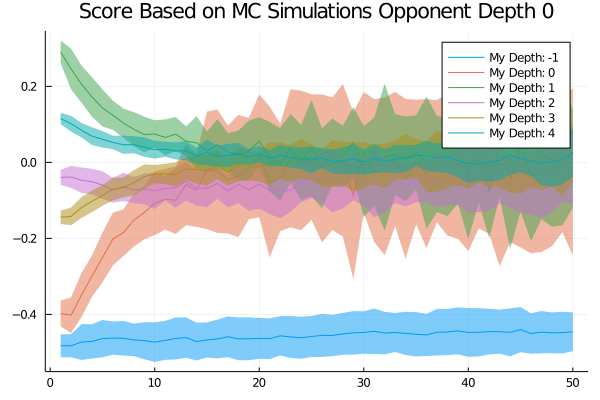

Opponent Depth: 0, Expirment #30


In [26]:
simulate_opponent_depth(0, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

My Depth: -1
Opponent Depth: 1, Expirment #1
Opponent Depth: 1, Expirment #2
Opponent Depth: 1, Expirment #3
Opponent Depth: 1, Expirment #4
Opponent Depth: 1, Expirment #5
Opponent Depth: 1, Expirment #6
Opponent Depth: 1, Expirment #7
Opponent Depth: 1, Expirment #8
Opponent Depth: 1, Expirment #9
Opponent Depth: 1, Expirment #10
Opponent Depth: 1, Expirment #11
Opponent Depth: 1, Expirment #12
Opponent Depth: 1, Expirment #13
Opponent Depth: 1, Expirment #14
Opponent Depth: 1, Expirment #15
Opponent Depth: 1, Expirment #16
Opponent Depth: 1, Expirment #17
Opponent Depth: 1, Expirment #18
Opponent Depth: 1, Expirment #19
Opponent Depth: 1, Expirment #20
Opponent Depth: 1, Expirment #21
Opponent Depth: 1, Expirment #22
Opponent Depth: 1, Expirment #23
Opponent Depth: 1, Expirment #24
Opponent Depth: 1, Expirment #25
Opponent Depth: 1, Expirment #26
Opponent Depth: 1, Expirment #27
Opponent Depth: 1, Expirment #28
Opponent Depth: 1, Expirment #29
Opponent Depth: 1, Expirment #30
My Dep

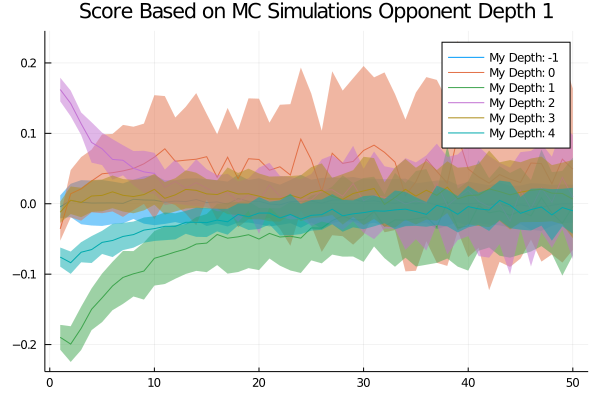

Opponent Depth: 1, Expirment #30


In [27]:
simulate_opponent_depth(1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

My Depth: -1
Opponent Depth: 2, Expirment #1
Opponent Depth: 2, Expirment #2
Opponent Depth: 2, Expirment #3
Opponent Depth: 2, Expirment #4
Opponent Depth: 2, Expirment #5
Opponent Depth: 2, Expirment #6
Opponent Depth: 2, Expirment #7
Opponent Depth: 2, Expirment #8
Opponent Depth: 2, Expirment #9
Opponent Depth: 2, Expirment #10
Opponent Depth: 2, Expirment #11
Opponent Depth: 2, Expirment #12
Opponent Depth: 2, Expirment #13
Opponent Depth: 2, Expirment #14
Opponent Depth: 2, Expirment #15
Opponent Depth: 2, Expirment #16
Opponent Depth: 2, Expirment #17
Opponent Depth: 2, Expirment #18
Opponent Depth: 2, Expirment #19
Opponent Depth: 2, Expirment #20
Opponent Depth: 2, Expirment #21
Opponent Depth: 2, Expirment #22
Opponent Depth: 2, Expirment #23
Opponent Depth: 2, Expirment #24
Opponent Depth: 2, Expirment #25
Opponent Depth: 2, Expirment #26
Opponent Depth: 2, Expirment #27
Opponent Depth: 2, Expirment #28
Opponent Depth: 2, Expirment #29
Opponent Depth: 2, Expirment #30
My Dep

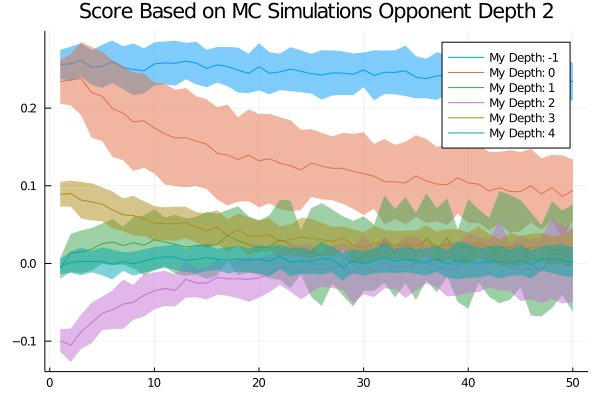

Opponent Depth: 2, Expirment #30


In [28]:
simulate_opponent_depth(2, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

My Depth: -1
Opponent Depth: 3, Expirment #1
Opponent Depth: 3, Expirment #2
Opponent Depth: 3, Expirment #3
Opponent Depth: 3, Expirment #4
Opponent Depth: 3, Expirment #5
Opponent Depth: 3, Expirment #6
Opponent Depth: 3, Expirment #7
Opponent Depth: 3, Expirment #8
Opponent Depth: 3, Expirment #9
Opponent Depth: 3, Expirment #10
Opponent Depth: 3, Expirment #11
Opponent Depth: 3, Expirment #12
Opponent Depth: 3, Expirment #13
Opponent Depth: 3, Expirment #14
Opponent Depth: 3, Expirment #15
Opponent Depth: 3, Expirment #16
Opponent Depth: 3, Expirment #17
Opponent Depth: 3, Expirment #18
Opponent Depth: 3, Expirment #19
Opponent Depth: 3, Expirment #20
Opponent Depth: 3, Expirment #21
Opponent Depth: 3, Expirment #22
Opponent Depth: 3, Expirment #23
Opponent Depth: 3, Expirment #24
Opponent Depth: 3, Expirment #25
Opponent Depth: 3, Expirment #26
Opponent Depth: 3, Expirment #27
Opponent Depth: 3, Expirment #28
Opponent Depth: 3, Expirment #29
Opponent Depth: 3, Expirment #30
My Dep

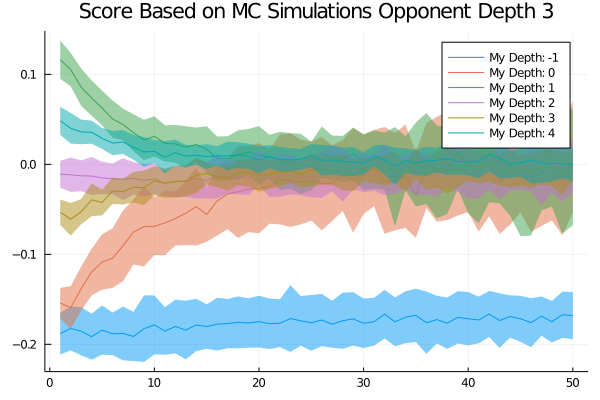


Opponent Depth: 3, Expirment #30


In [29]:
simulate_opponent_depth(3, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

My Depth: -1
Opponent Depth: 4, Expirment #1
Opponent Depth: 4, Expirment #2
Opponent Depth: 4, Expirment #3
Opponent Depth: 4, Expirment #4
Opponent Depth: 4, Expirment #5
Opponent Depth: 4, Expirment #6
Opponent Depth: 4, Expirment #7
Opponent Depth: 4, Expirment #8
Opponent Depth: 4, Expirment #9
Opponent Depth: 4, Expirment #10
Opponent Depth: 4, Expirment #11
Opponent Depth: 4, Expirment #12
Opponent Depth: 4, Expirment #13
Opponent Depth: 4, Expirment #14
Opponent Depth: 4, Expirment #15
Opponent Depth: 4, Expirment #16
Opponent Depth: 4, Expirment #17
Opponent Depth: 4, Expirment #18
Opponent Depth: 4, Expirment #19
Opponent Depth: 4, Expirment #20
Opponent Depth: 4, Expirment #21
Opponent Depth: 4, Expirment #22
Opponent Depth: 4, Expirment #23
Opponent Depth: 4, Expirment #24
Opponent Depth: 4, Expirment #25
Opponent Depth: 4, Expirment #26
Opponent Depth: 4, Expirment #27
Opponent Depth: 4, Expirment #28
Opponent Depth: 4, Expirment #29
Opponent Depth: 4, Expirment #30
My Dep

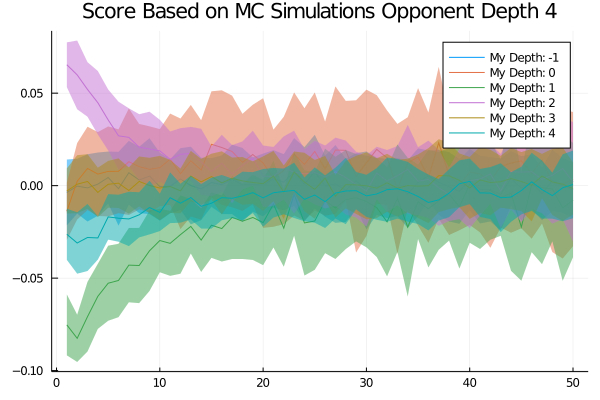


Opponent Depth: 4, Expirment #30


In [30]:
simulate_opponent_depth(4, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

In [ ]:
simulate_opponent_depth(5, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

In [ ]:
simulate_opponent_depth(6, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS, 6)

My Depth: -1
Opponent Depth: 6, Expirment #1
Opponent Depth: 6, Expirment #2
Opponent Depth: 6, Expirment #3
Opponent Depth: 6, Expirment #4
Opponent Depth: 6, Expirment #5
Opponent Depth: 6, Expirment #6
Opponent Depth: 6, Expirment #7
Opponent Depth: 6, Expirment #8
Opponent Depth: 6, Expirment #9
Opponent Depth: 6, Expirment #10
Opponent Depth: 6, Expirment #11
Opponent Depth: 6, Expirment #12
Opponent Depth: 6, Expirment #13
Opponent Depth: 6, Expirment #14
Opponent Depth: 6, Expirment #15
Opponent Depth: 6, Expirment #16
Opponent Depth: 6, Expirment #17
Opponent Depth: 6, Expirment #18
Opponent Depth: 6, Expirment #19
Opponent Depth: 6, Expirment #20
Opponent Depth: 6, Expirment #21
Opponent Depth: 6, Expirment #22
Opponent Depth: 6, Expirment #23
Opponent Depth: 6, Expirment #24
Opponent Depth: 6, Expirment #25
Opponent Depth: 6, Expirment #26
Opponent Depth: 6, Expirment #27
Opponent Depth: 6, Expirment #28
Opponent Depth: 6, Expirment #29
Opponent Depth: 6, Expirment #30
My Dep

In [ ]:
simulate_opponent_depth(7, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 

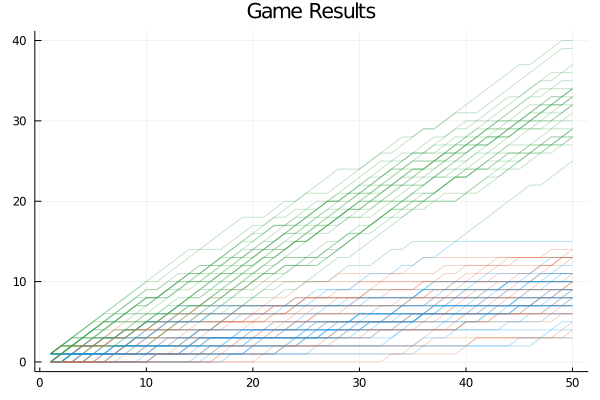

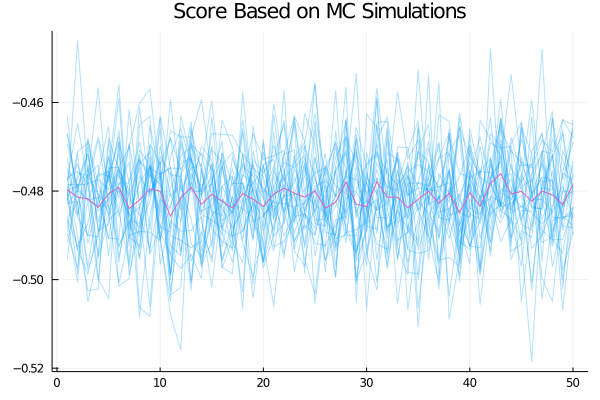

first win: 8.6+-2.5810984029124584
ties: 9.466666666666667+-3.01414290823517
second win: 31.933333333333334+-3.5519138438344737


In [49]:
simulate_game(-1, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:39
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:36
Progress: 100%|█████████████████████████████████████████| Time: 0:02:36
Progress: 100%|█████████████████████████████████████████| Time: 0:02:36
Progress: 100%|█████████████████████████████████████████| Time: 0:02:38
Progress: 100%|█████████████████████████████████████████| Time: 0:02:36
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:39
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 

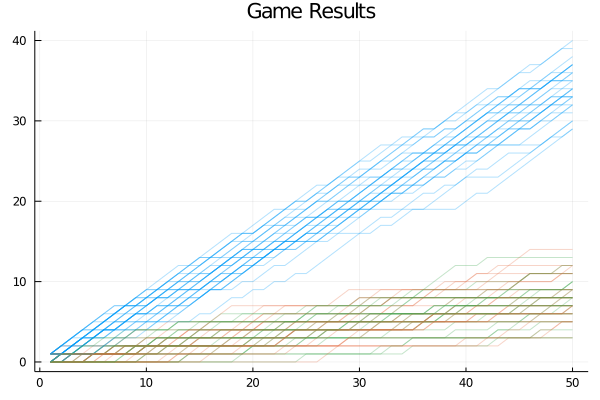

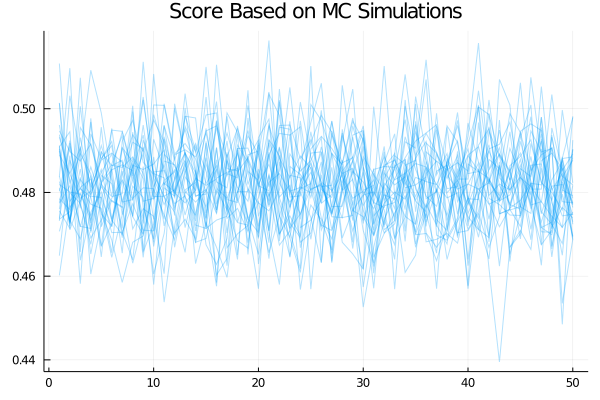

first win: 34.13333333333333+-2.849480694773182
ties: 8.066666666666666+-2.585547808736935
second win: 7.8+-2.4551142960963244


In [117]:
simulate_game(-1, -1, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:29
Progress: 100%|█████████████████████████████████████████| Time: 

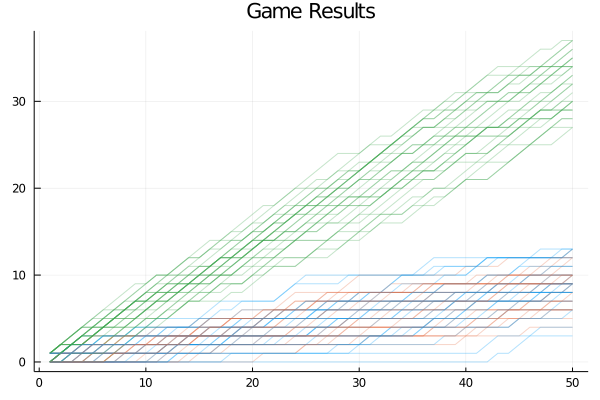

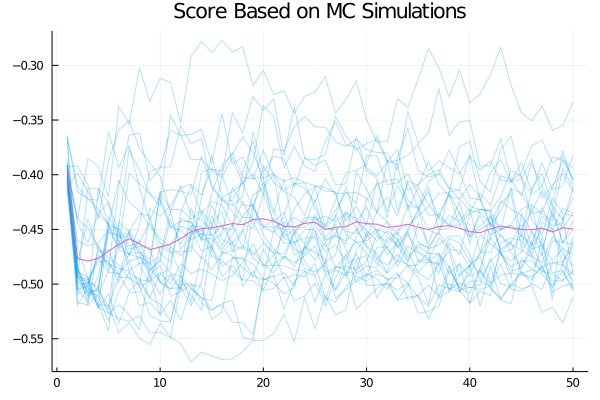

first win: 9.133333333333333+-2.5289132643984793
ties: 8.6+-2.2682212383731217
second win: 32.266666666666666+-3.106537415297566


In [50]:
simulate_game(0, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 

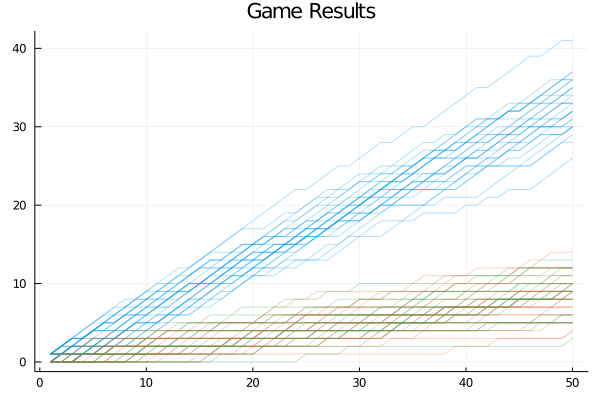

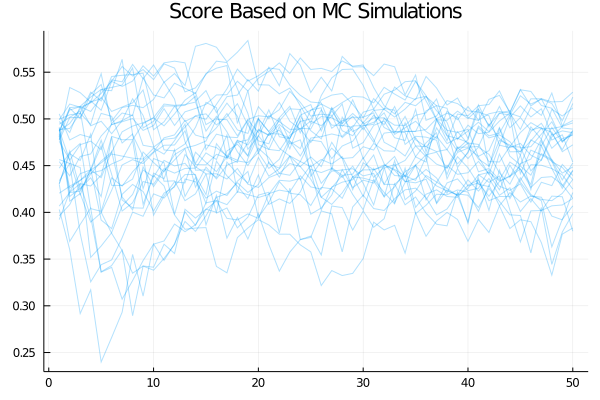

first win: 32.9+-3.1769645022058177
ties: 8.3+-2.534588315887707
second win: 8.8+-2.5243640373574188


In [120]:
simulate_game(-1, 0, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

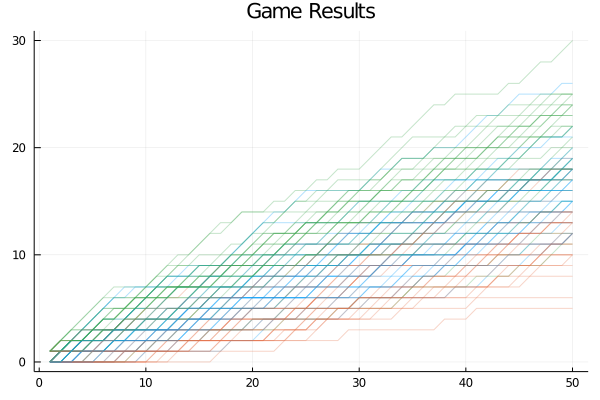

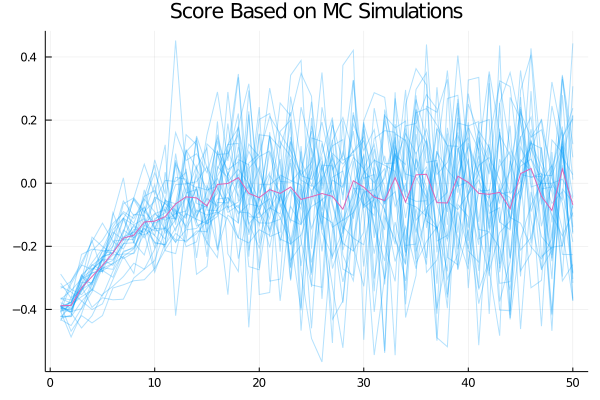

first win: 16.733333333333334+-3.1832897030168867
ties: 12.633333333333333+-3.4188456746578133
second win: 20.633333333333333+-4.189340605947872


In [39]:
simulate_game(0, 0, [1,10,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:07
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:07
Progress: 100%|█████████████████████████████████████████| Time: 0:04:07
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 

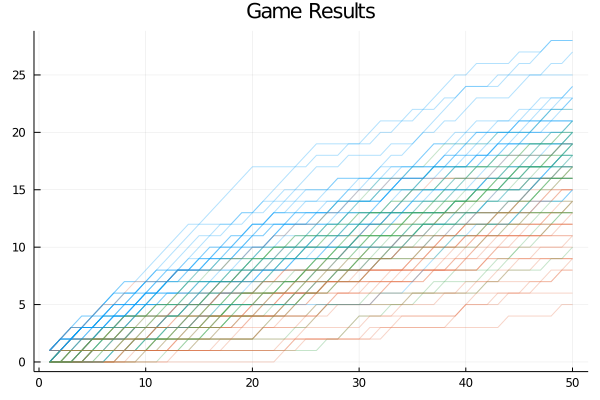

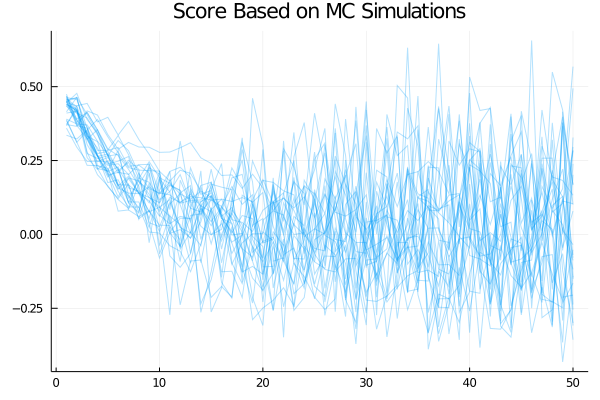

first win: 20.733333333333334+-3.4931789033163927
ties: 12.233333333333333+-3.4208622963479125
second win: 17.033333333333335+-2.8464537323790657


In [122]:
simulate_game(0, 0, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 0:09:38
Progress: 100%|█████████████████████████████████████████| Time: 0:09:42
Progress: 100%|█████████████████████████████████████████| Time: 0:09:43
Progress: 100%|█████████████████████████████████████████| Time: 0:09:35
Progress: 100%|█████████████████████████████████████████| Time: 0:09:36
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 

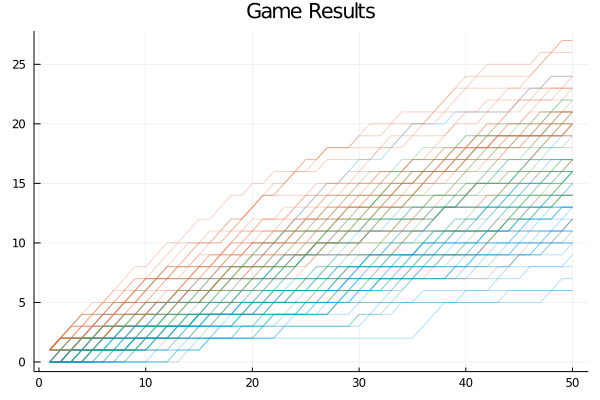

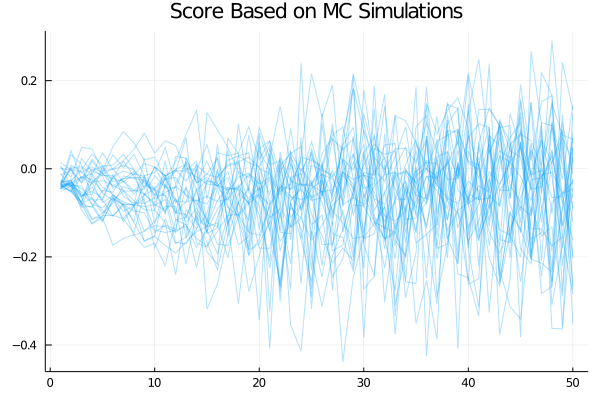

first win: 12.5+-3.8573709109738963
ties: 20.566666666666666+-3.6829835481701454
second win: 16.933333333333334+-2.778406059215437


In [123]:
simulate_game(0, 1, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(1, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(1, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(1, 1, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(1, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:21
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:20
Progress: 100%|█████████████████████████████████████████| Time: 0:15:22
Progress: 100%|█████████████████████████████████████████| Time: 0:15:41
Progress: 100%|█████████████████████████████████████████| Time: 0:15:31
Progress: 100%|█████████████████████████████████████████| Time: 0:15:17
Progress: 100%|█████████████████████████████████████████| Time: 0:15:13
Progress: 100%|█████████████████████████████████████████| Time: 0:15:15
Progress: 100%|█████████████████████████████████████████| Time: 

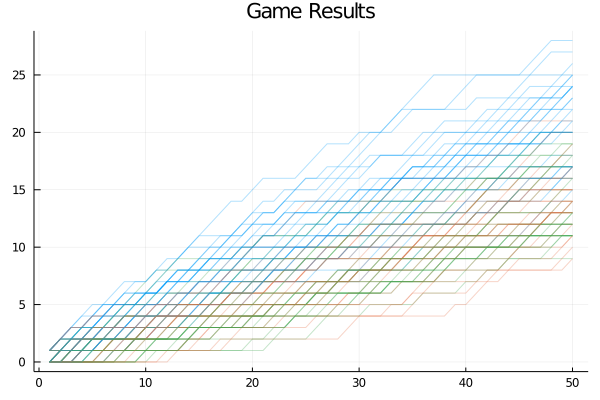

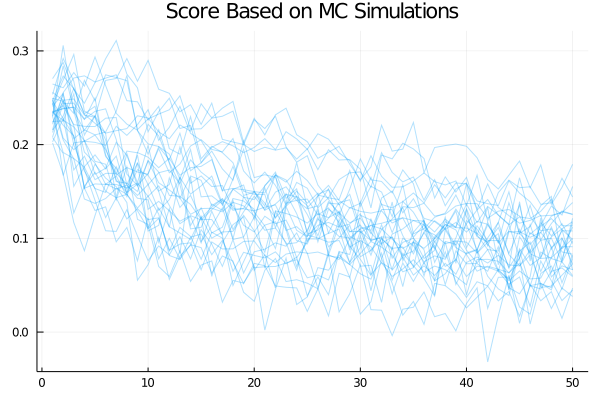

first win: 21.4+-3.538945878511635
ties: 14.433333333333334+-2.8488755595889033
second win: 14.166666666666666+-3.1413080224572094


In [131]:
simulate_game(2, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:34
Progress: 100%|█████████████████████████████████████████| Time: 0:20:37
Progress: 100%|█████████████████████████████████████████| Time: 0:20:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:37
Progress: 100%|█████████████████████████████████████████| Time: 0:20:33
Progress: 100%|█████████████████████████████████████████| Time: 0:20:48
Progress: 100%|█████████████████████████████████████████| Time: 0:20:33
Progress: 100%|█████████████████████████████████████████| Time: 0:20:28
Progress: 100%|█████████████████████████████████████████| Time: 0:20:59
Progress: 100%|█████████████████████████████████████████| Time: 0:20:51
Progress: 100%|█████████████████████████████████████████| Time: 0:20:29
Progress: 100%|█████████████████████████████████████████| Time: 

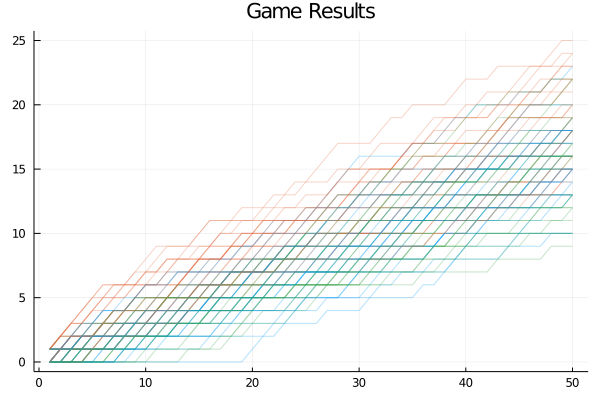

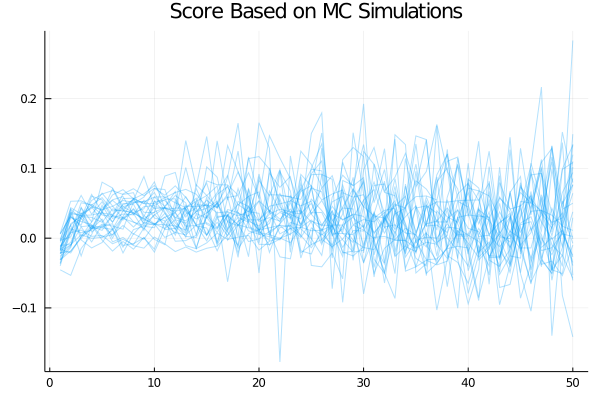

first win: 15.833333333333334+-2.7926422210359565
ties: 19.0+-3.2905297760233916
second win: 15.166666666666666+-3.5630608048208456


In [127]:
simulate_game(2, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:23
Progress: 100%|█████████████████████████████████████████| Time: 0:20:28
Progress: 100%|█████████████████████████████████████████| Time: 0:20:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:23
Progress: 100%|█████████████████████████████████████████| Time: 0:20:28
Progress: 100%|█████████████████████████████████████████| Time: 0:20:27
Progress: 100%|█████████████████████████████████████████| Time: 0:20:27
Progress: 100%|█████████████████████████████████████████| Time: 0:20:25
Progress: 100%|█████████████████████████████████████████| Time: 0:20:26
Progress: 100%|█████████████████████████████████████████| Time: 0:20:23
Progress: 100%|█████████████████████████████████████████| Time: 0:20:24
Progress: 100%|█████████████████████████████████████████| Time: 0:20:28
Progress: 100%|█████████████████████████████████████████| Time: 0:20:24
Progress: 100%|█████████████████████████████████████████| Time: 

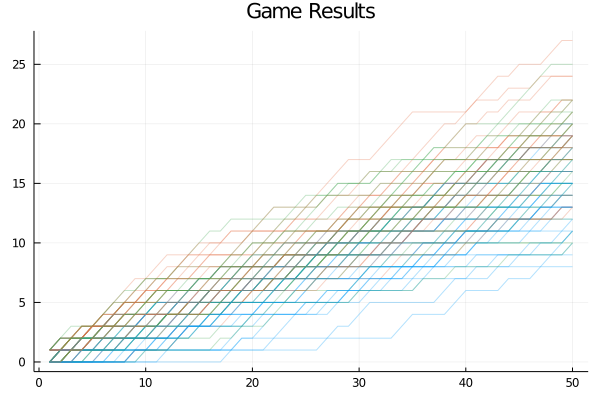

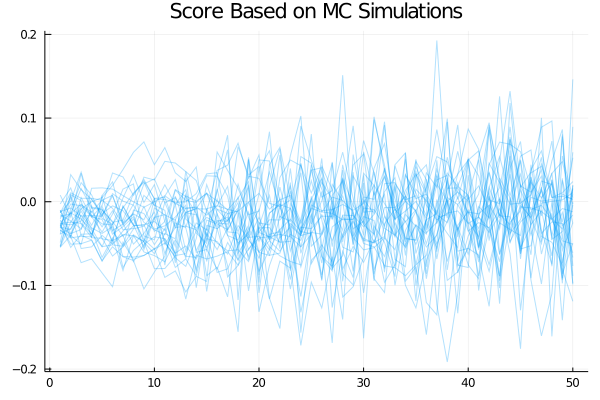

first win: 14.233333333333333+-2.990598294809843
ties: 18.4+-3.5389458785116346
second win: 17.366666666666667+-3.652899965906477


In [128]:
simulate_game(1, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:25:44
Progress: 100%|█████████████████████████████████████████| Time: 0:25:40
Progress: 100%|█████████████████████████████████████████| Time: 0:25:31
Progress: 100%|█████████████████████████████████████████| Time: 0:25:40
Progress: 100%|█████████████████████████████████████████| Time: 0:25:31
Progress: 100%|█████████████████████████████████████████| Time: 0:25:36
Progress: 100%|█████████████████████████████████████████| Time: 0:25:36
Progress: 100%|█████████████████████████████████████████| Time: 0:25:32
Progress: 100%|█████████████████████████████████████████| Time: 0:25:37
Progress: 100%|█████████████████████████████████████████| Time: 0:25:34
Progress: 100%|█████████████████████████████████████████| Time: 0:25:43
Progress: 100%|█████████████████████████████████████████| Time: 0:25:38
Progress: 100%|█████████████████████████████████████████| Time: 0:26:36
Progress: 100%|█████████████████████████████████████████| Time: 

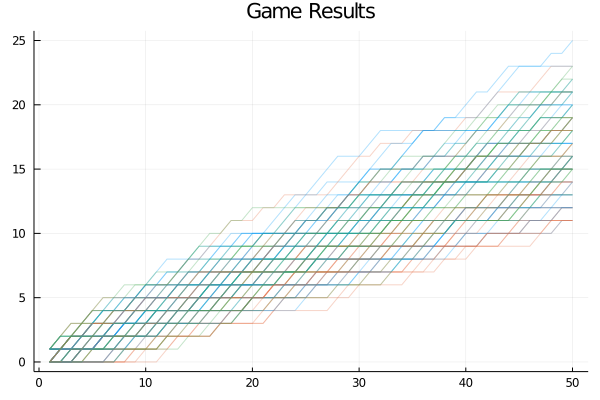

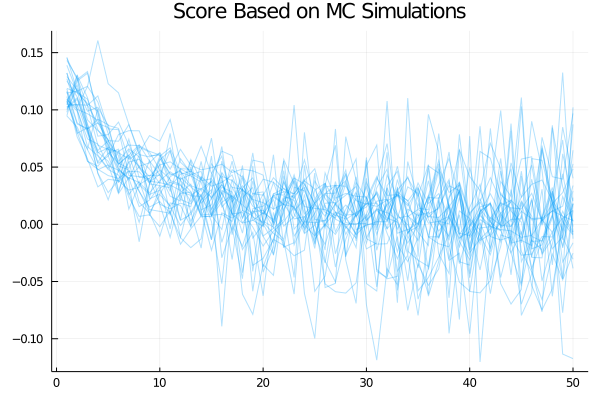

first win: 17.0+-3.723179953415795
ties: 15.033333333333333+-3.2322014845584133
second win: 17.966666666666665+-2.6455340811852426


In [129]:
simulate_game(2, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:26:06
Progress: 100%|█████████████████████████████████████████| Time: 0:26:12
Progress: 100%|█████████████████████████████████████████| Time: 0:26:04
Progress: 100%|█████████████████████████████████████████| Time: 0:26:11
Progress: 100%|█████████████████████████████████████████| Time: 0:26:18
Progress: 100%|█████████████████████████████████████████| Time: 0:26:09
Progress: 100%|█████████████████████████████████████████| Time: 0:26:02
Progress: 100%|█████████████████████████████████████████| Time: 0:26:17
Progress: 100%|█████████████████████████████████████████| Time: 0:26:05
Progress: 100%|█████████████████████████████████████████| Time: 0:26:12
Progress: 100%|█████████████████████████████████████████| Time: 0:26:04
Progress: 100%|█████████████████████████████████████████| Time: 0:26:18
Progress: 100%|█████████████████████████████████████████| Time: 0:26:10
Progress: 100%|█████████████████████████████████████████| Time: 

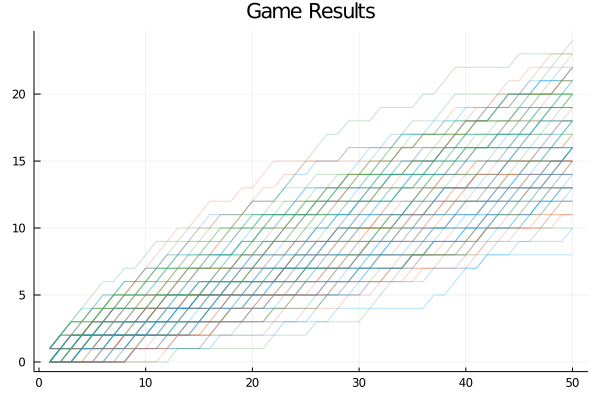

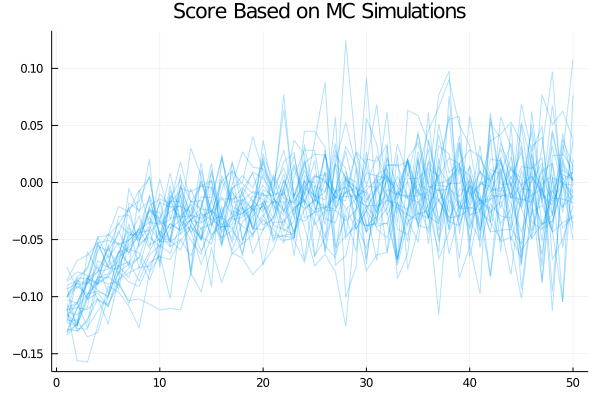

first win: 15.833333333333334+-3.444969679395454
ties: 16.0+-3.6577739603244463
second win: 18.166666666666668+-3.1082019786735042


In [130]:
simulate_game(2, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:32
Progress: 100%|█████████████████████████████████████████| Time: 0:15:20
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:16:04
Progress: 100%|█████████████████████████████████████████| Time: 0:16:09
Progress: 100%|█████████████████████████████████████████| Time: 0:15:57
Progress: 100%|█████████████████████████████████████████| Time: 0:15:00
Progress: 100%|█████████████████████████████████████████| Time: 0:14:54
Progress: 100%|█████████████████████████████████████████| Time: 0:14:57
Progress: 100%|█████████████████████████████████████████| Time: 0:14:53
Progress: 100%|█████████████████████████████████████████| Time: 

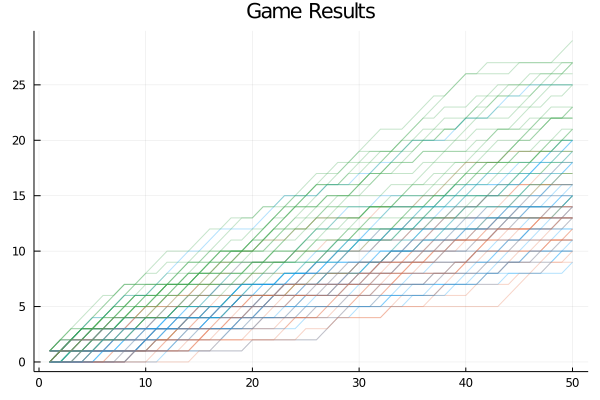

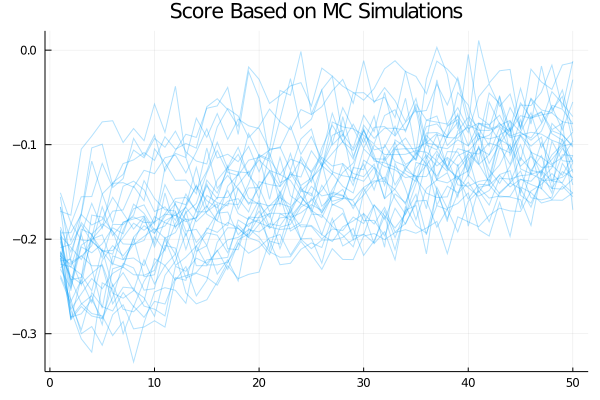

first win: 14.833333333333334+-3.7146804135366267
ties: 13.466666666666667+-2.37419072721536
second win: 21.7+-3.869865898059714


In [132]:
simulate_game(0, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:21
Progress: 100%|█████████████████████████████████████████| Time: 0:20:00
Progress: 100%|█████████████████████████████████████████| Time: 0:20:02
Progress: 100%|█████████████████████████████████████████| Time: 0:20:01
Progress: 100%|█████████████████████████████████████████| Time: 0:20:03
Progress: 100%|█████████████████████████████████████████| Time: 0:20:00
Progress: 100%|█████████████████████████████████████████| Time: 0:20:03
Progress: 100%|█████████████████████████████████████████| Time: 0:20:12
Progress: 100%|█████████████████████████████████████████| Time: 0:20:08
Progress: 100%|█████████████████████████████████████████| Time: 0:20:05
Progress: 100%|█████████████████████████████████████████| Time: 0:20:05
Progress: 100%|█████████████████████████████████████████| Time: 0:20:08
Progress: 100%|█████████████████████████████████████████| Time: 0:20:10
Progress: 100%|█████████████████████████████████████████| Time: 

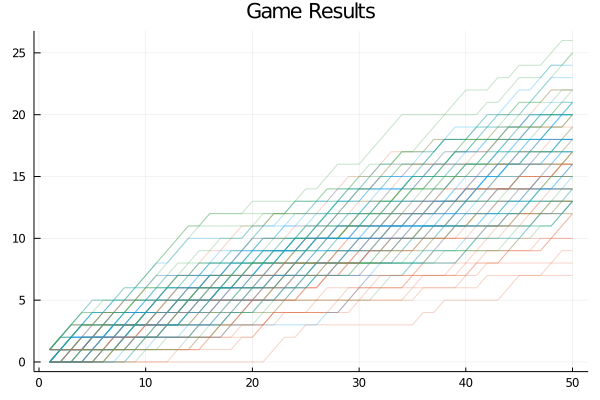

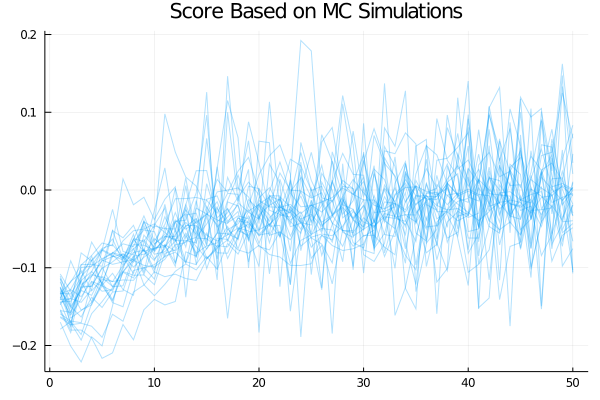

first win: 17.666666666666668+-2.97499154833147
ties: 14.533333333333333+-3.5982115608704284
second win: 17.8+-4.063292363045786


In [133]:
simulate_game(3, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:23:30
Progress: 100%|█████████████████████████████████████████| Time: 0:23:26
Progress: 100%|█████████████████████████████████████████| Time: 0:23:28
Progress: 100%|█████████████████████████████████████████| Time: 0:23:25
Progress: 100%|█████████████████████████████████████████| Time: 0:23:31
Progress: 100%|█████████████████████████████████████████| Time: 0:23:18
Progress: 100%|█████████████████████████████████████████| Time: 0:23:12
Progress: 100%|█████████████████████████████████████████| Time: 0:23:12
Progress: 100%|█████████████████████████████████████████| Time: 0:23:15
Progress: 100%|█████████████████████████████████████████| Time: 0:23:16
Progress: 100%|█████████████████████████████████████████| Time: 0:23:16
Progress: 100%|█████████████████████████████████████████| Time: 0:23:34
Progress: 100%|█████████████████████████████████████████| Time: 0:23:19
Progress: 100%|█████████████████████████████████████████| Time: 

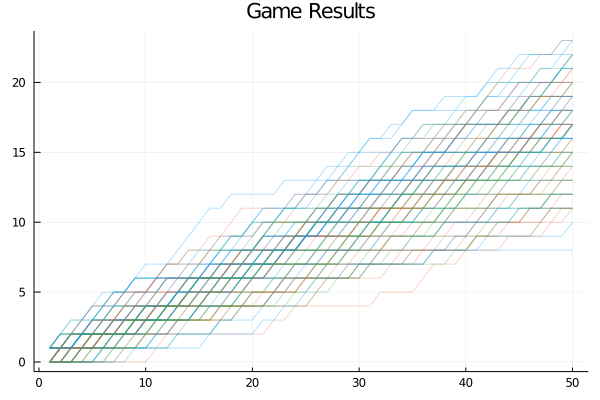

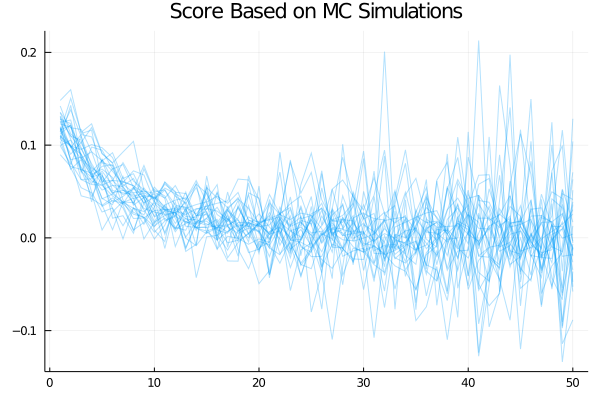

first win: 17.333333333333332+-3.7077117521163383
ties: 16.433333333333334+-3.410767264609729
second win: 16.233333333333334+-3.2021903423290983


In [25]:
simulate_game(3, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:32:15
Progress: 100%|█████████████████████████████████████████| Time: 0:30:12
Progress: 100%|█████████████████████████████████████████| Time: 0:46:27
Progress: 100%|█████████████████████████████████████████| Time: 0:37:07
Progress: 100%|█████████████████████████████████████████| Time: 0:29:03
Progress: 100%|█████████████████████████████████████████| Time: 0:28:44
Progress: 100%|█████████████████████████████████████████| Time: 0:28:48
Progress: 100%|█████████████████████████████████████████| Time: 0:28:37
Progress: 100%|█████████████████████████████████████████| Time: 0:28:46
Progress: 100%|█████████████████████████████████████████| Time: 0:28:53
Progress: 100%|█████████████████████████████████████████| Time: 0:28:46
Progress: 100%|█████████████████████████████████████████| Time: 0:28:44
Progress: 100%|█████████████████████████████████████████| Time: 0:28:47
Progress: 100%|█████████████████████████████████████████| Time: 

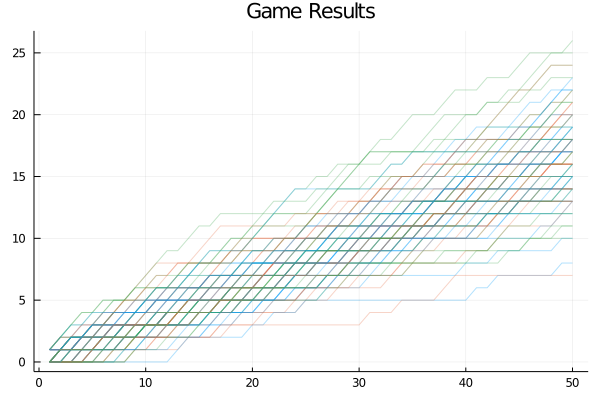

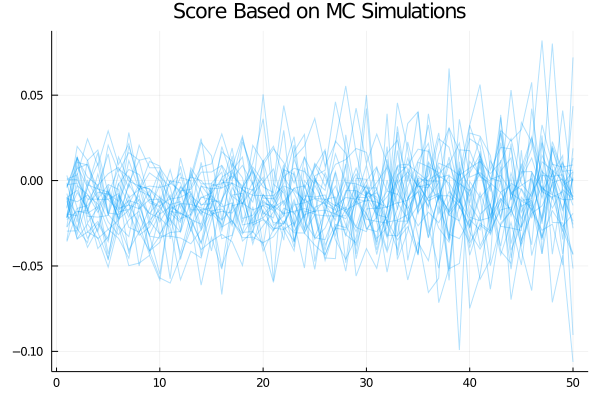

first win: 16.366666666666667+-3.4986039908880047
ties: 16.566666666666666+-3.4309276249749265
second win: 17.066666666666666+-4.298623142302687


In [24]:
simulate_game(3, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:08:49
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:37
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:41
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:40
Progress: 100%|█████████████████████████████████████████| Time: 0:08:42
Progress: 100%|█████████████████████████████████████████| Time: 0:08:41
Progress: 100%|█████████████████████████████████████████| Time: 0:08:43
Progress: 100%|█████████████████████████████████████████| Time: 0:08:38
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 

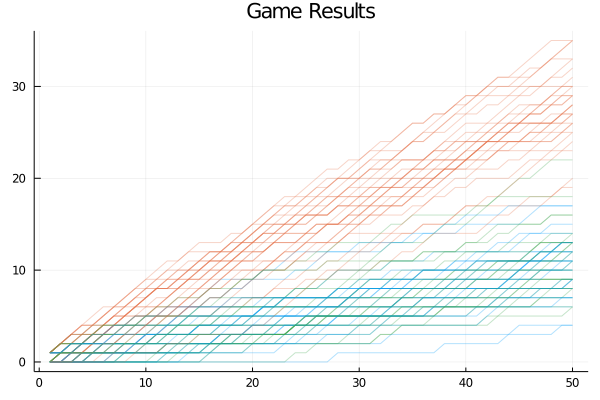

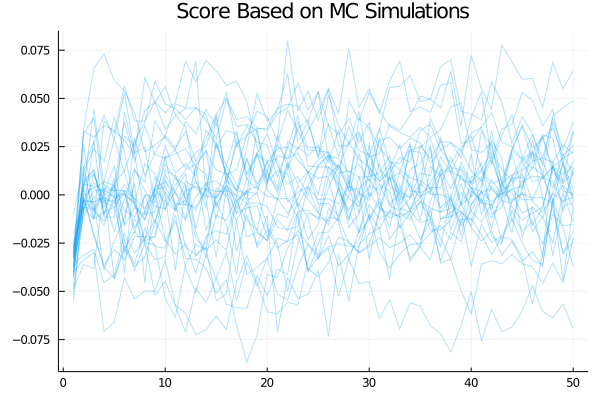

first win: 10.6+-3.3176643217366246
ties: 28.2+-3.9688441816139663
second win: 11.2+-3.6521132285955704


In [26]:
simulate_game(1, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:13:19
Progress: 100%|█████████████████████████████████████████| Time: 0:13:21
Progress: 100%|█████████████████████████████████████████| Time: 0:13:18
Progress: 100%|█████████████████████████████████████████| Time: 0:13:22
Progress: 100%|█████████████████████████████████████████| Time: 0:13:17
Progress: 100%|█████████████████████████████████████████| Time: 0:13:17
Progress: 100%|█████████████████████████████████████████| Time: 0:13:21
Progress: 100%|█████████████████████████████████████████| Time: 0:13:17
Progress: 100%|█████████████████████████████████████████| Time: 0:13:20
Progress: 100%|█████████████████████████████████████████| Time: 0:13:20
Progress: 100%|█████████████████████████████████████████| Time: 0:13:19
Progress: 100%|█████████████████████████████████████████| Time: 0:13:21
Progress: 100%|█████████████████████████████████████████| Time: 0:13:19
Progress: 100%|█████████████████████████████████████████| Time: 

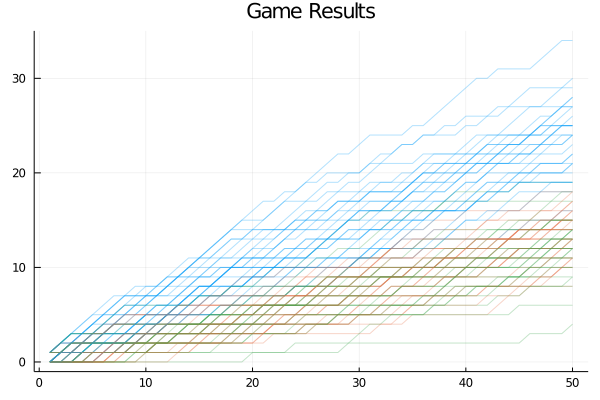

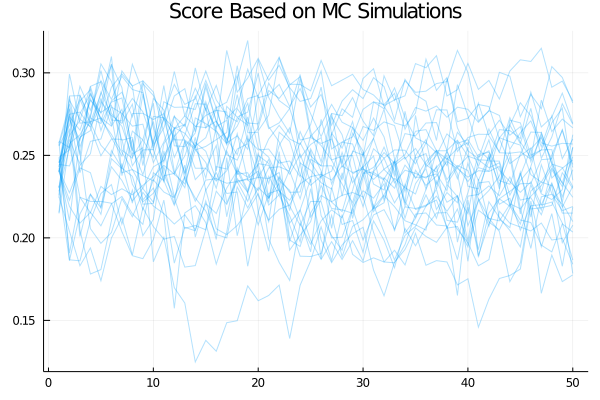

first win: 23.933333333333334+-3.9647875390599507
ties: 13.6+-2.513412297914997
second win: 12.466666666666667+-3.2561171432512546


In [27]:
simulate_game(2, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:18:28
Progress: 100%|█████████████████████████████████████████| Time: 0:17:58
Progress: 100%|█████████████████████████████████████████| Time: 0:18:00
Progress: 100%|█████████████████████████████████████████| Time: 0:18:09
Progress: 100%|█████████████████████████████████████████| Time: 0:18:02
Progress: 100%|█████████████████████████████████████████| Time: 0:18:02
Progress: 100%|█████████████████████████████████████████| Time: 0:18:01
Progress: 100%|█████████████████████████████████████████| Time: 0:17:57
Progress: 100%|█████████████████████████████████████████| Time: 0:17:58
Progress: 100%|█████████████████████████████████████████| Time: 0:18:18
Progress: 100%|█████████████████████████████████████████| Time: 0:17:54
Progress: 100%|█████████████████████████████████████████| Time: 0:17:55
Progress: 100%|█████████████████████████████████████████| Time: 0:18:01
Progress: 100%|█████████████████████████████████████████| Time: 

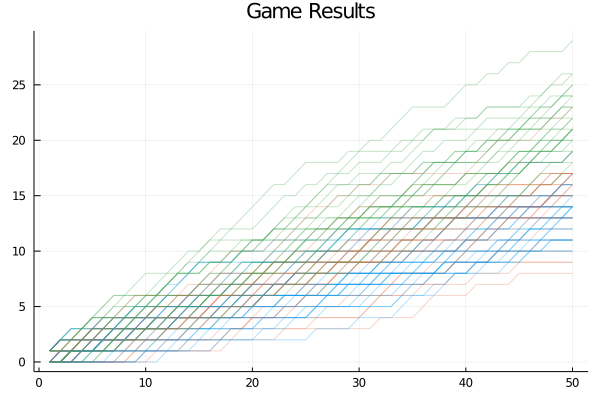

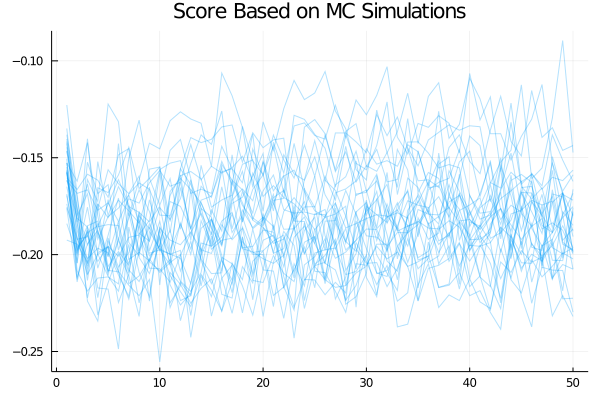

first win: 13.6+-2.14315268897852
ties: 14.7+-3.2286433576712192
second win: 21.7+-2.866573107267691


In [28]:
simulate_game(3, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:36:00
Progress: 100%|█████████████████████████████████████████| Time: 0:31:56
Progress: 100%|█████████████████████████████████████████| Time: 0:31:00
Progress: 100%|█████████████████████████████████████████| Time: 0:31:56
Progress: 100%|█████████████████████████████████████████| Time: 0:28:30
Progress: 100%|█████████████████████████████████████████| Time: 0:23:03
Progress: 100%|█████████████████████████████████████████| Time: 0:23:54
Progress: 100%|█████████████████████████████████████████| Time: 0:23:07
Progress: 100%|█████████████████████████████████████████| Time: 0:23:12
Progress: 100%|█████████████████████████████████████████| Time: 0:24:55
Progress: 100%|█████████████████████████████████████████| Time: 0:23:33
Progress: 100%|█████████████████████████████████████████| Time: 0:23:22
Progress: 100%|█████████████████████████████████████████| Time: 0:23:01
Progress: 100%|█████████████████████████████████████████| Time: 

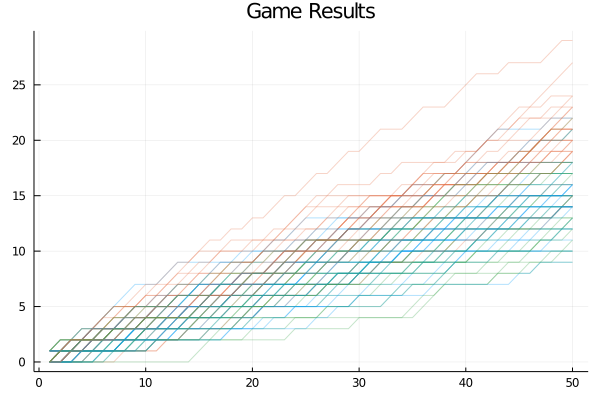

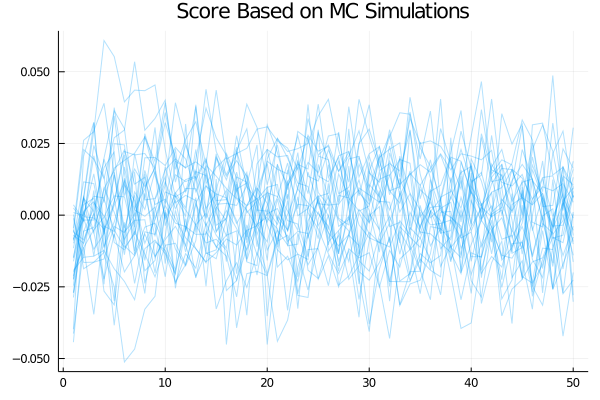

first win: 14.866666666666667+-2.9680288749098866
ties: 20.3+-3.4556300887602003
second win: 14.833333333333334+-3.1303115778964625


In [30]:
simulate_game(4, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:22:47
Progress: 100%|█████████████████████████████████████████| Time: 0:22:51
Progress: 100%|█████████████████████████████████████████| Time: 0:22:48
Progress: 100%|█████████████████████████████████████████| Time: 0:22:49
Progress: 100%|█████████████████████████████████████████| Time: 0:22:48
Progress: 100%|█████████████████████████████████████████| Time: 0:22:45
Progress: 100%|█████████████████████████████████████████| Time: 0:22:49
Progress: 100%|█████████████████████████████████████████| Time: 0:22:50
Progress: 100%|█████████████████████████████████████████| Time: 0:22:45
Progress: 100%|█████████████████████████████████████████| Time: 0:22:48
Progress: 100%|█████████████████████████████████████████| Time: 0:22:49
Progress: 100%|█████████████████████████████████████████| Time: 0:22:46
Progress: 100%|█████████████████████████████████████████| Time: 0:22:47
Progress: 100%|█████████████████████████████████████████| Time: 

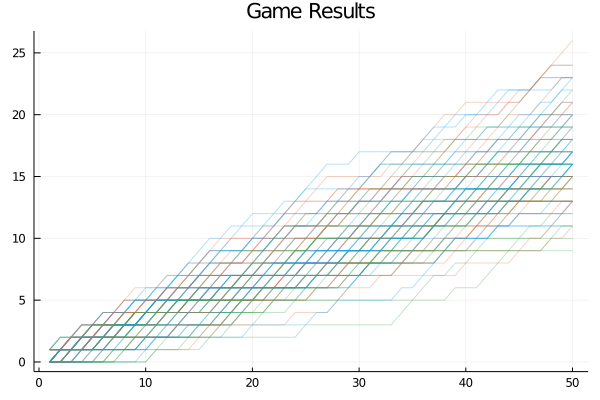

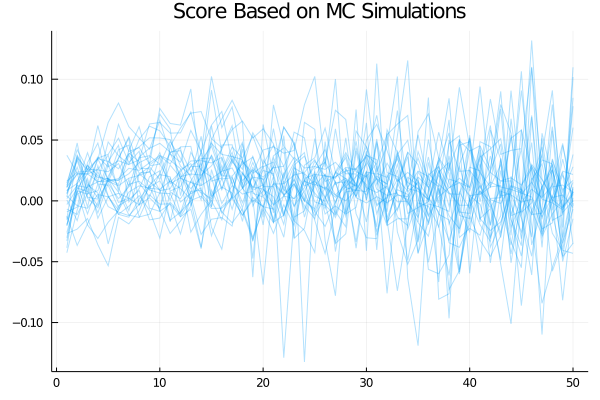

first win: 17.4+-3.1579128856102807
ties: 16.9+-3.9597108915712
second win: 15.7+-3.4255631301467337


In [31]:
simulate_game(4, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:27:48
Progress: 100%|█████████████████████████████████████████| Time: 0:27:52
Progress: 100%|█████████████████████████████████████████| Time: 0:27:49
Progress: 100%|█████████████████████████████████████████| Time: 0:27:50
Progress: 100%|█████████████████████████████████████████| Time: 0:36:33
Progress: 100%|█████████████████████████████████████████| Time: 0:31:04
Progress: 100%|█████████████████████████████████████████| Time: 0:31:11
Progress: 100%|█████████████████████████████████████████| Time: 0:29:31
Progress: 100%|█████████████████████████████████████████| Time: 0:32:07
Progress: 100%|█████████████████████████████████████████| Time: 0:41:19
Progress: 100%|█████████████████████████████████████████| Time: 0:35:41
Progress: 100%|█████████████████████████████████████████| Time: 0:33:49
Progress: 100%|█████████████████████████████████████████| Time: 0:29:49
Progress: 100%|█████████████████████████████████████████| Time: 

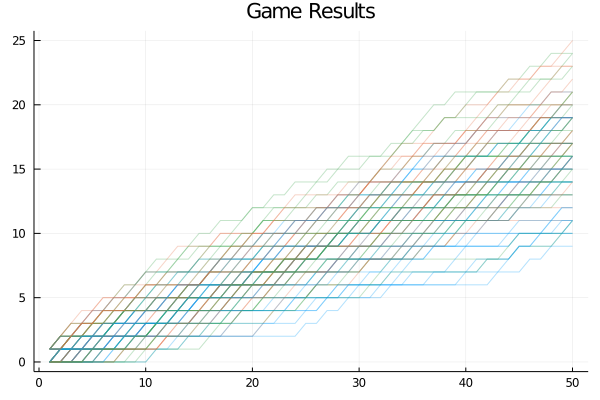

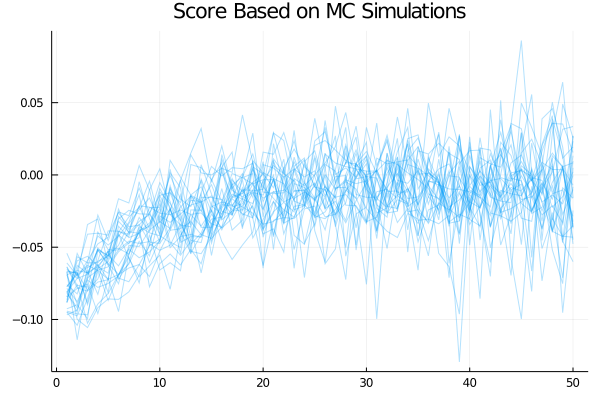

first win: 14.933333333333334+-3.4434679124928422
ties: 17.866666666666667+-3.2561171432512546
second win: 17.2+-3.4481379282757527


In [32]:
simulate_game(4, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:32:39
Progress: 100%|█████████████████████████████████████████| Time: 0:32:38
Progress: 100%|█████████████████████████████████████████| Time: 0:32:35
Progress: 100%|█████████████████████████████████████████| Time: 0:32:30
Progress: 100%|█████████████████████████████████████████| Time: 0:32:39
Progress: 100%|█████████████████████████████████████████| Time: 0:32:35
Progress: 100%|█████████████████████████████████████████| Time: 0:32:38
Progress: 100%|█████████████████████████████████████████| Time: 0:32:23
Progress: 100%|█████████████████████████████████████████| Time: 0:32:24
Progress: 100%|█████████████████████████████████████████| Time: 0:32:22
Progress: 100%|█████████████████████████████████████████| Time: 0:32:23
Progress: 100%|█████████████████████████████████████████| Time: 0:32:23
Progress: 100%|█████████████████████████████████████████| Time: 0:32:20
Progress: 100%|█████████████████████████████████████████| Time: 

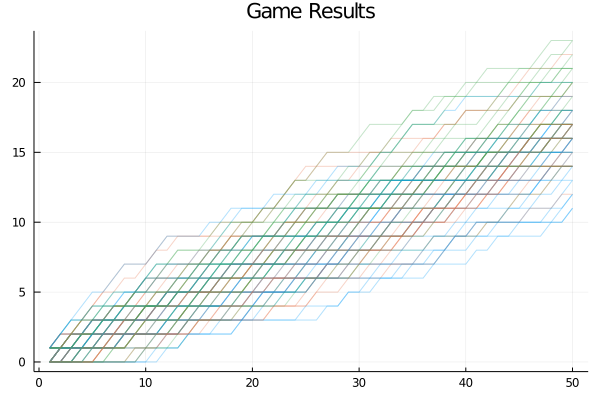

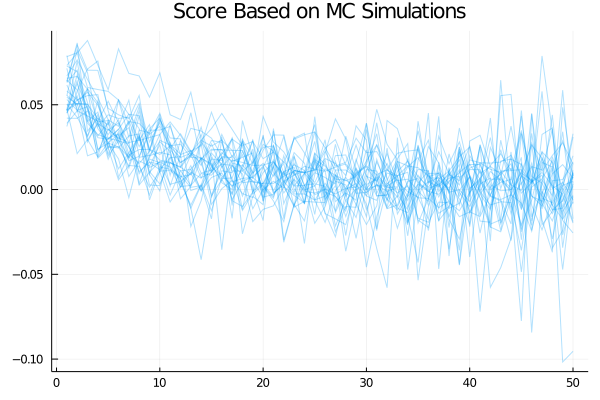

first win: 15.5+-2.3006745637477417
ties: 16.333333333333332+-2.0733669657618843
second win: 18.166666666666668+-2.614064523559687


In [33]:
simulate_game(4, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

TODO: תוצאה ממוצעת

Progress: 100%|█████████████████████████████████████████| Time: 0:39:52
Progress: 100%|█████████████████████████████████████████| Time: 0:38:55
Progress: 100%|█████████████████████████████████████████| Time: 0:38:16
Progress: 100%|█████████████████████████████████████████| Time: 0:37:56
Progress: 100%|█████████████████████████████████████████| Time: 0:38:01
Progress: 100%|█████████████████████████████████████████| Time: 0:37:56
Progress: 100%|█████████████████████████████████████████| Time: 0:38:13
Progress: 100%|█████████████████████████████████████████| Time: 0:38:00
Progress: 100%|█████████████████████████████████████████| Time: 0:38:02
Progress: 100%|█████████████████████████████████████████| Time: 0:38:00
Progress: 100%|█████████████████████████████████████████| Time: 0:37:56
Progress: 100%|█████████████████████████████████████████| Time: 0:37:56
Progress: 100%|█████████████████████████████████████████| Time: 0:38:03
Progress: 100%|█████████████████████████████████████████| Time: 

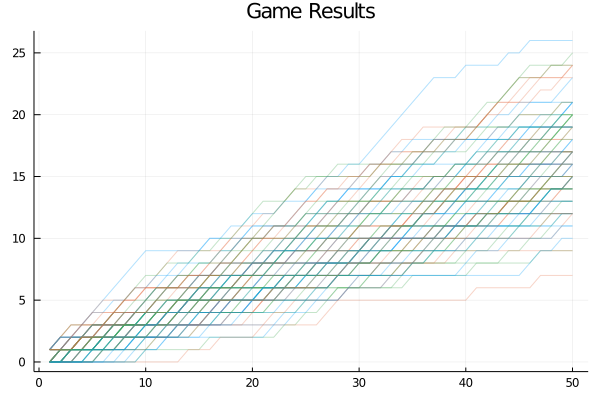

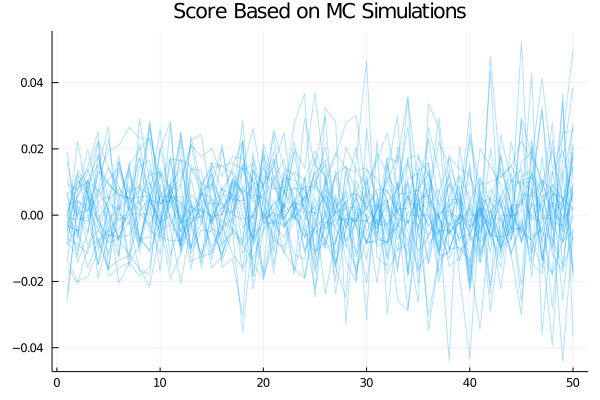

first win: 16.466666666666665+-3.892816844973026
ties: 16.466666666666665+-4.133407489138274
second win: 17.066666666666666+-3.71328772748981


In [34]:
simulate_game(4, 3, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:48:08
Progress: 100%|█████████████████████████████████████████| Time: 0:48:15
Progress: 100%|█████████████████████████████████████████| Time: 0:46:22
Progress: 100%|█████████████████████████████████████████| Time: 0:42:01
Progress: 100%|█████████████████████████████████████████| Time: 0:41:45
Progress: 100%|█████████████████████████████████████████| Time: 0:41:41
Progress: 100%|█████████████████████████████████████████| Time: 0:41:46
Progress: 100%|█████████████████████████████████████████| Time: 0:41:56
Progress: 100%|█████████████████████████████████████████| Time: 0:41:33
Progress: 100%|█████████████████████████████████████████| Time: 0:41:37
Progress: 100%|█████████████████████████████████████████| Time: 0:41:39
Progress: 100%|█████████████████████████████████████████| Time: 0:41:46
Progress: 100%|█████████████████████████████████████████| Time: 0:41:40
Progress: 100%|█████████████████████████████████████████| Time: 

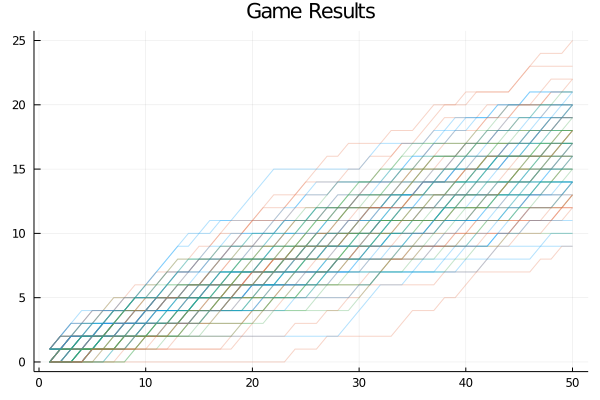

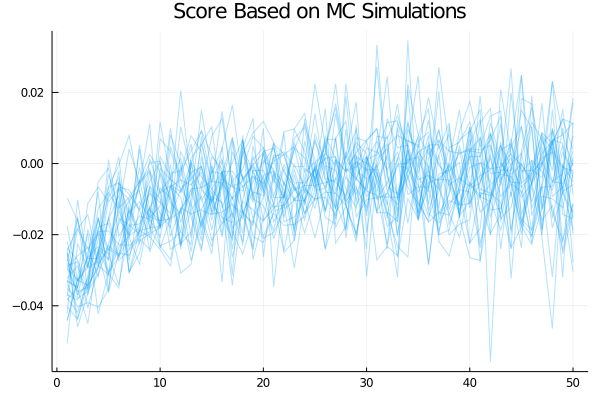

first win: 16.533333333333335+-3.350072910512117
ties: 16.8+-3.942692935825322
second win: 16.666666666666668+-2.3242845889810293


In [35]:
simulate_game(4, 4, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [38]:
using PyPlot
function simulate_grid(first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = 10)
    fig, axs = subplots(6, 6, sharey=true, sharex=true) 
    fig.suptitle("Score Based on MC Simulations")
    for my_depth in -1:4
       for opponent_depth in -1:my_depth
            println("opponent_depth #$my_depth my_depth #$opponent_depth")
            axs[my_depth+2, opponent_depth+2].set_title("$my_depth, $opponent_depth")
            for i in 1:num_of_expirements
                println("expirment #$i")
                game_result = game(my_depth, opponent_depth, first_player_prior_policy, second_player_prior_policy)
                _, _ , mc_score = game_result
                axs[my_depth+2, opponent_depth+2].plot(mc_score, alpha=0.1, color="blue")
            end
        end
    end
end

simulate_grid (generic function with 4 methods)

In [ ]:
simulate_grid([1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

opponent_depth #-1 my_depth #-1
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:02:38


expirment #2

Progress:   2%|█                                        |  ETA: 0:02:29

Progress:  74%|███████████████████████████████          |  ETA: 0:00:43

LoadError: InterruptException:

In [41]:
print("asd")

asd

## Summery
* The history overwrite the prior pretty fast when looking on history
* when adding theory of mind from 0 to 1 the player succeed to exploit the inbalanced prior
* when going towards higher depth's we see that the effect above not working anymore (but the result is going to Nash-EQ). need more expirments
* we need to see how larger then 1 difference in theory of mind parameter affect the results

TODO:
* increase the num of rounds
* adding more example with different levels of theory of mind (2,0) , (0, 2)